In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0
import os

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64
num_classes = 4

In [ ]:
train_dir = '/content/drive/Shareddrives/FYP/single_cell_data/train'
val_dir = '/content/drive/Shareddrives/FYP/single_cell_data/validation'

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),  # Initial resizing during loading
    batch_size=None,
    color_mode = "grayscale"
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),  # Initial resizing during loading
    batch_size=None,
    color_mode = "grayscale"
)

class_names = ds_train.class_names
NUM_CLASSES = len(class_names)

Found 5560 files belonging to 4 classes.
Found 1392 files belonging to 4 classes.


In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

In [ ]:
class_names

['A549', 'H2452', 'HEYA8', 'T24']

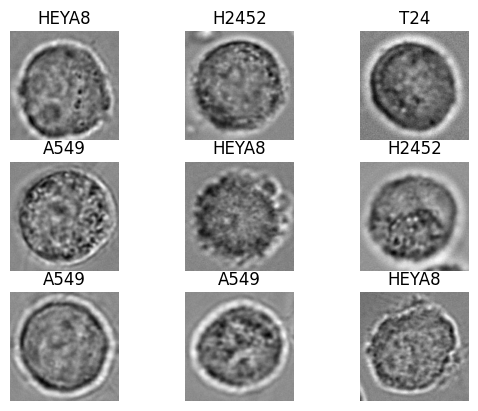

In [ ]:
def format_label(label):
    return class_names[label]

for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"), cmap='gray')
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### Data augmentation

In [ ]:
# Define augmentation layers
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    #layers.RandomContrast(factor=0.1),
]

def img_augmentation(image):
    # Apply all augmentation layers to the image
    for layer in img_augmentation_layers:
        image = layer(image)
    return image

# # Apply augmentation to the dataset
def augment_data(image, label):
    return img_augmentation(image), label

# # Apply the augmentation to the training dataset
ds_train_augmented = ds_train.map(augment_data)

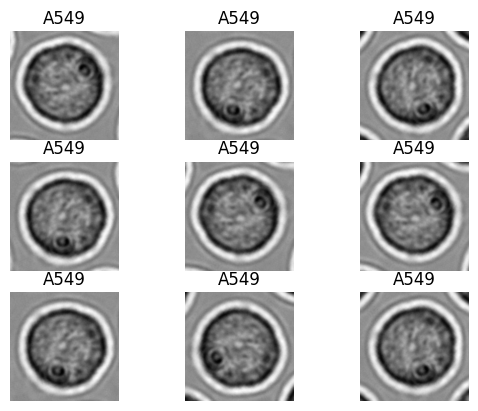

In [ ]:
# Plotting augmented images
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"), cmap='gray')
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [ ]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [ ]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
print(f'Training Dataset: {len(ds_train)} batchs')
print(f'Validation Dataset: {len(ds_test)} batchs')

Training Dataset: 86 batchs
Validation Dataset: 21 batchs


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class PlotMetrics(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        plt.figure(figsize=(12, 6))
        plt.plot(self.acc)
        plt.plot(self.val_acc)
        plt.title('Model Accuracy over Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
        plt.grid(True)
        plt.show()
  import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
# Model Training with Callback
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 80
plot_metrics = PlotMetrics()
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[plot_metrics])

In [ ]:
keras.config.disable_traceback_filtering()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 224, 224, 3)    │              7 │ rescaling_5[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization_4[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6811 - loss: 1.2228

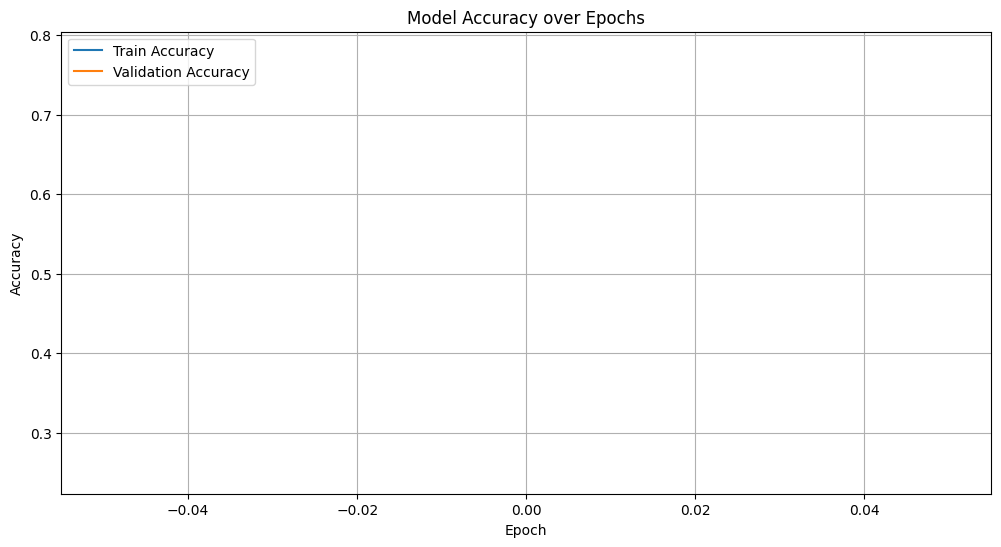

86/86 ━━━━━━━━━━━━━━━━━━━━ 130s 638ms/step - accuracy: 0.6822 - loss: 1.2171 - val_accuracy: 0.2500 - val_loss: 4.3765
Epoch 2/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8982 - loss: 0.2933

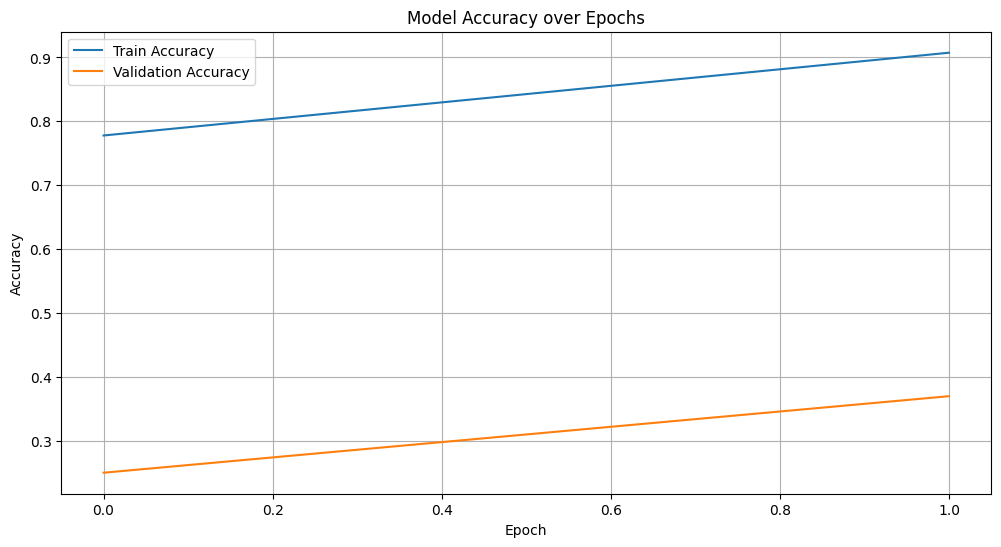

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 595ms/step - accuracy: 0.8983 - loss: 0.2930 - val_accuracy: 0.3698 - val_loss: 4.0601
Epoch 3/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9262 - loss: 0.2151

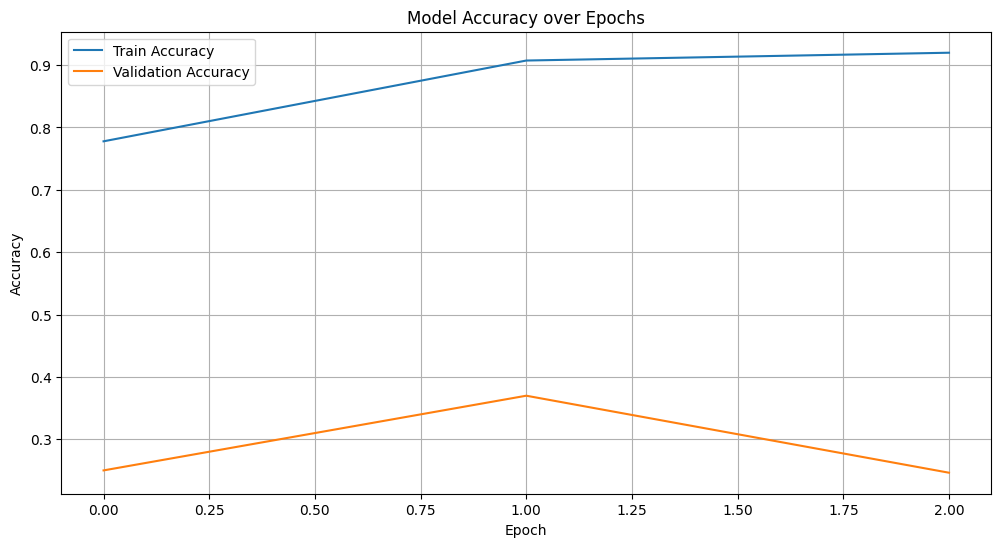

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 604ms/step - accuracy: 0.9261 - loss: 0.2152 - val_accuracy: 0.2463 - val_loss: 13.7250
Epoch 4/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9342 - loss: 0.1803

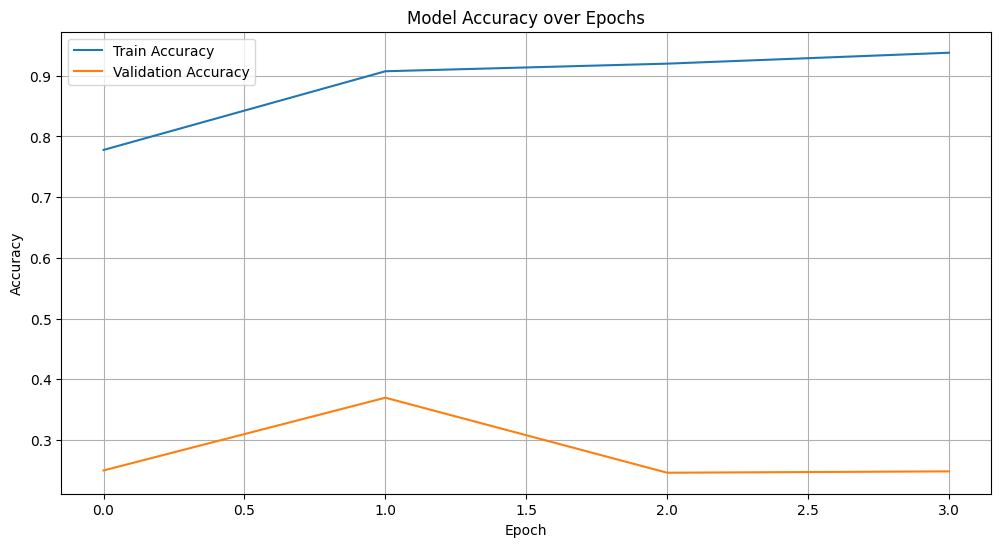

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 605ms/step - accuracy: 0.9342 - loss: 0.1801 - val_accuracy: 0.2485 - val_loss: 9.3248
Epoch 5/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9468 - loss: 0.1549

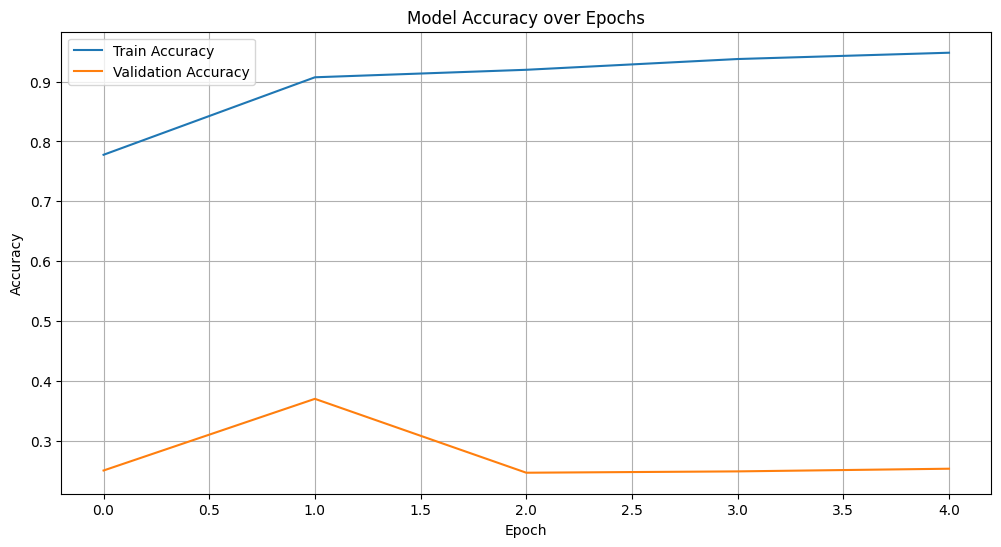

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 591ms/step - accuracy: 0.9468 - loss: 0.1548 - val_accuracy: 0.2530 - val_loss: 14.7606
Epoch 6/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9443 - loss: 0.1514

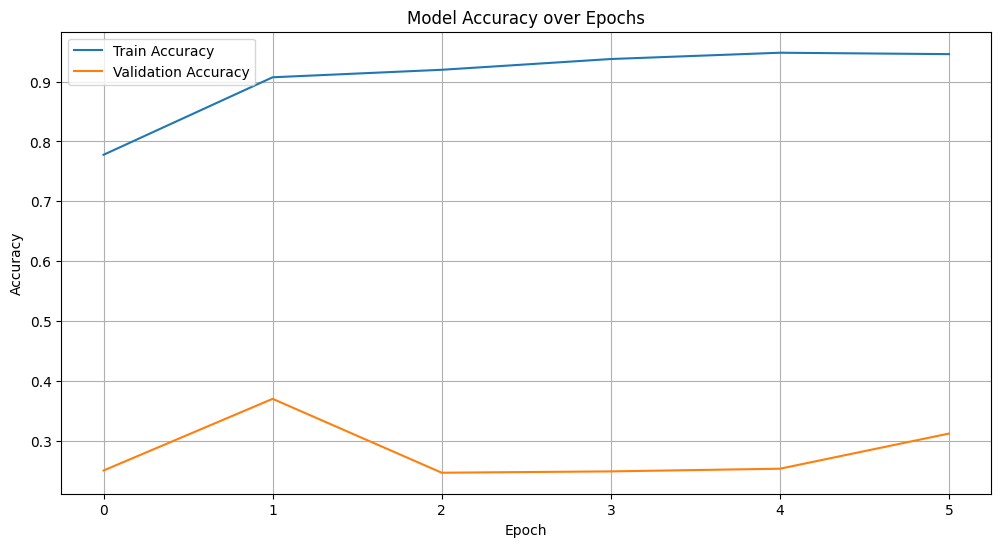

86/86 ━━━━━━━━━━━━━━━━━━━━ 50s 586ms/step - accuracy: 0.9443 - loss: 0.1513 - val_accuracy: 0.3118 - val_loss: 6.5533
Epoch 7/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9645 - loss: 0.0960

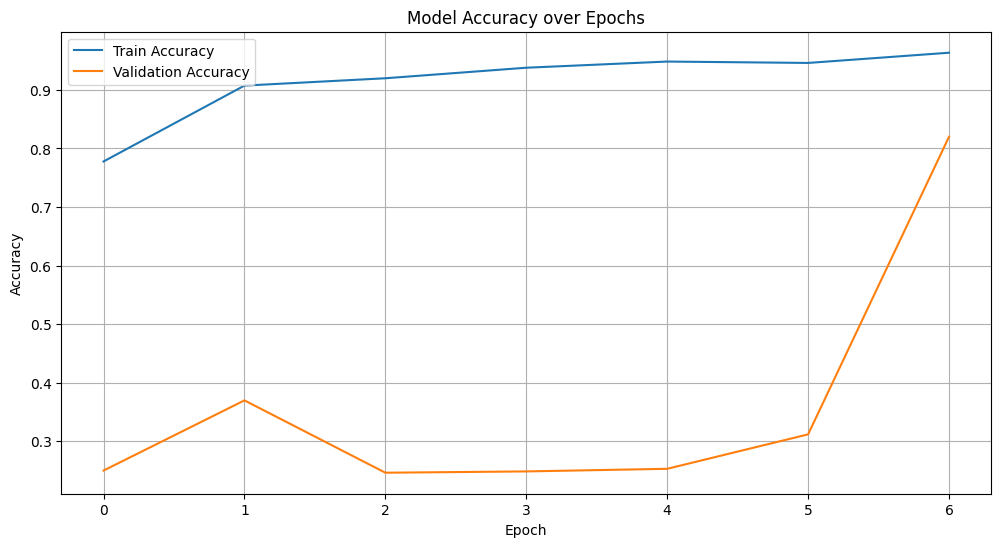

86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 595ms/step - accuracy: 0.9645 - loss: 0.0960 - val_accuracy: 0.8199 - val_loss: 0.5440
Epoch 8/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9627 - loss: 0.0988

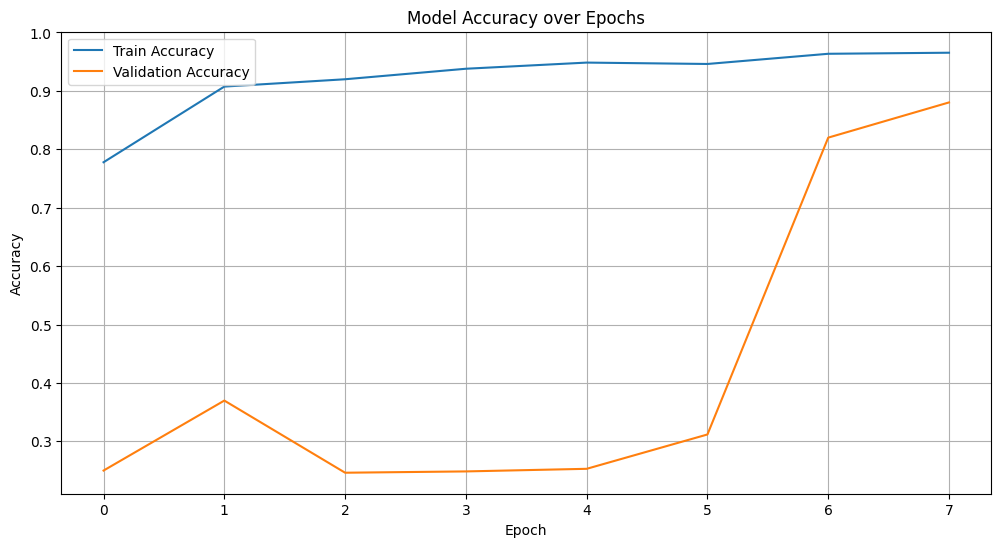

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 589ms/step - accuracy: 0.9627 - loss: 0.0987 - val_accuracy: 0.8802 - val_loss: 0.3302
Epoch 9/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9700 - loss: 0.0891

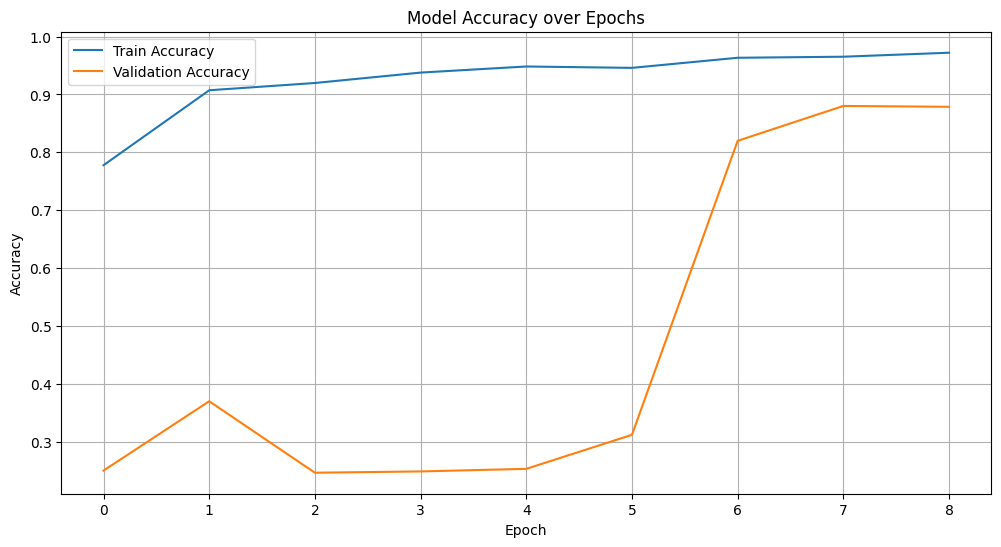

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 590ms/step - accuracy: 0.9700 - loss: 0.0890 - val_accuracy: 0.8787 - val_loss: 0.4189
Epoch 10/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9652 - loss: 0.1067

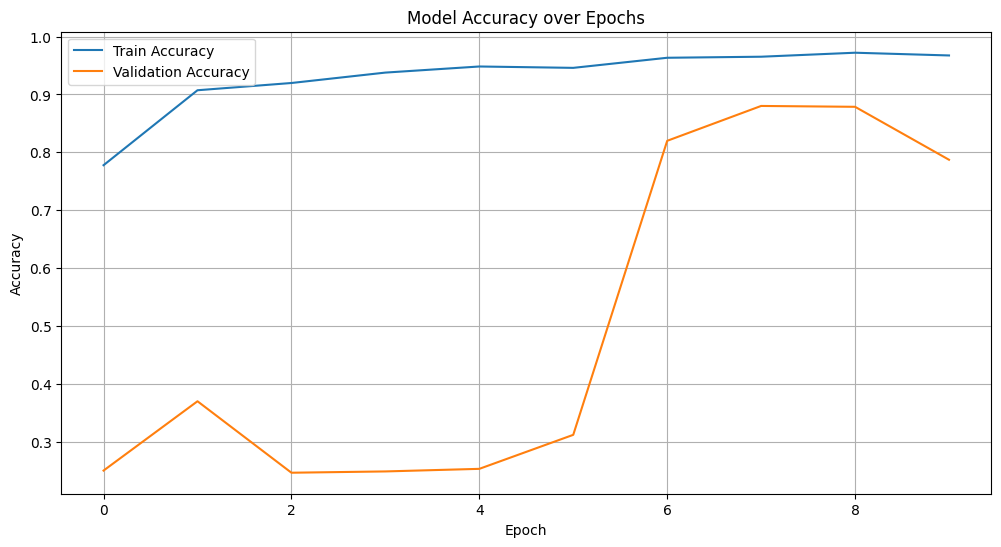

86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 581ms/step - accuracy: 0.9652 - loss: 0.1066 - val_accuracy: 0.7872 - val_loss: 0.6119
Epoch 11/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9731 - loss: 0.0742

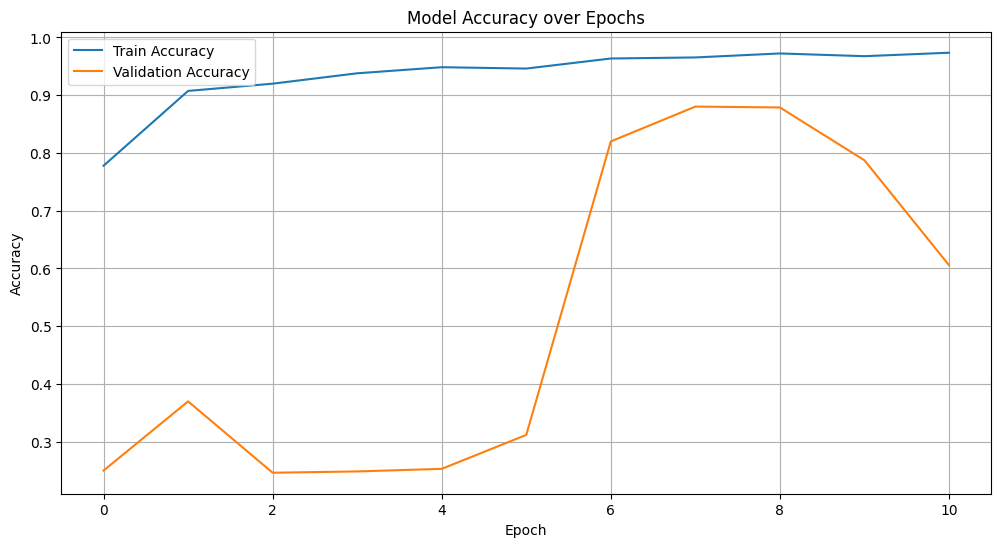

86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 598ms/step - accuracy: 0.9731 - loss: 0.0742 - val_accuracy: 0.6057 - val_loss: 2.3034
Epoch 12/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9835 - loss: 0.0526

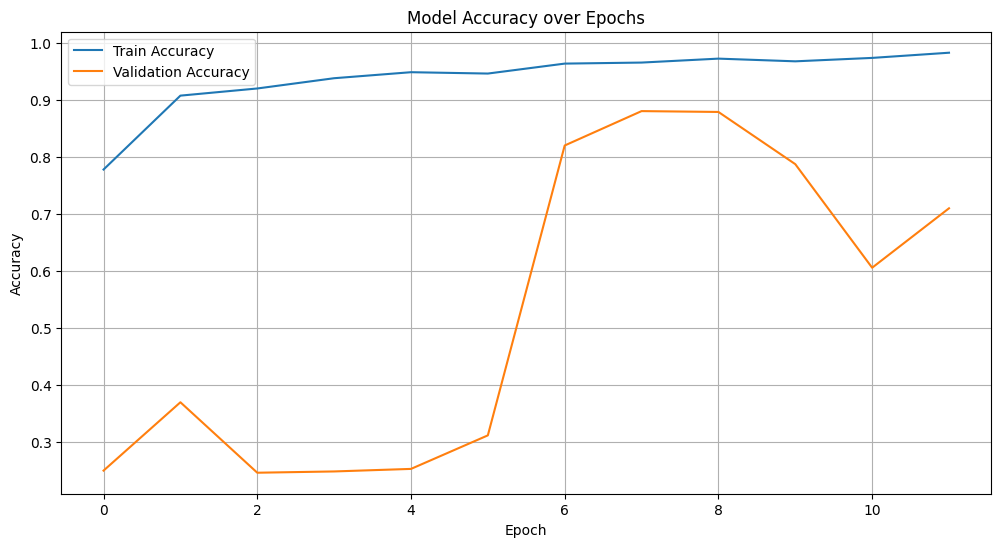

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 588ms/step - accuracy: 0.9835 - loss: 0.0526 - val_accuracy: 0.7098 - val_loss: 2.3493
Epoch 13/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9754 - loss: 0.0653

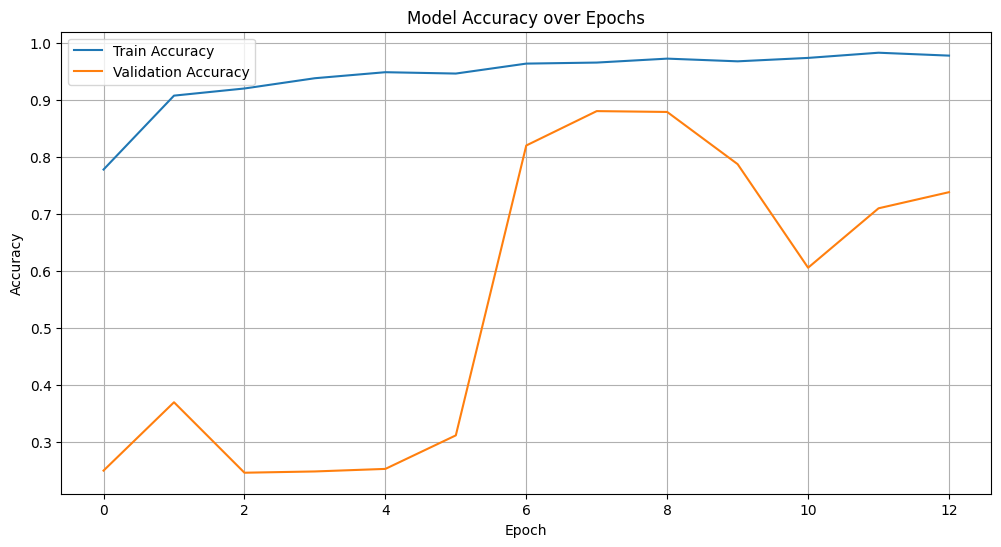

86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 605ms/step - accuracy: 0.9754 - loss: 0.0653 - val_accuracy: 0.7381 - val_loss: 1.6572
Epoch 14/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9741 - loss: 0.0779

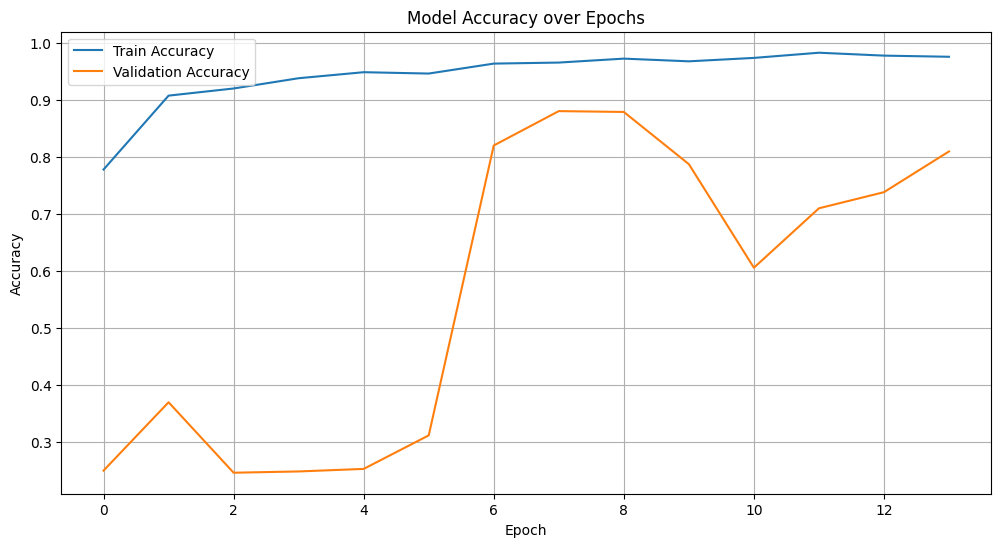

86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 615ms/step - accuracy: 0.9741 - loss: 0.0778 - val_accuracy: 0.8095 - val_loss: 0.5497
Epoch 15/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9807 - loss: 0.0585

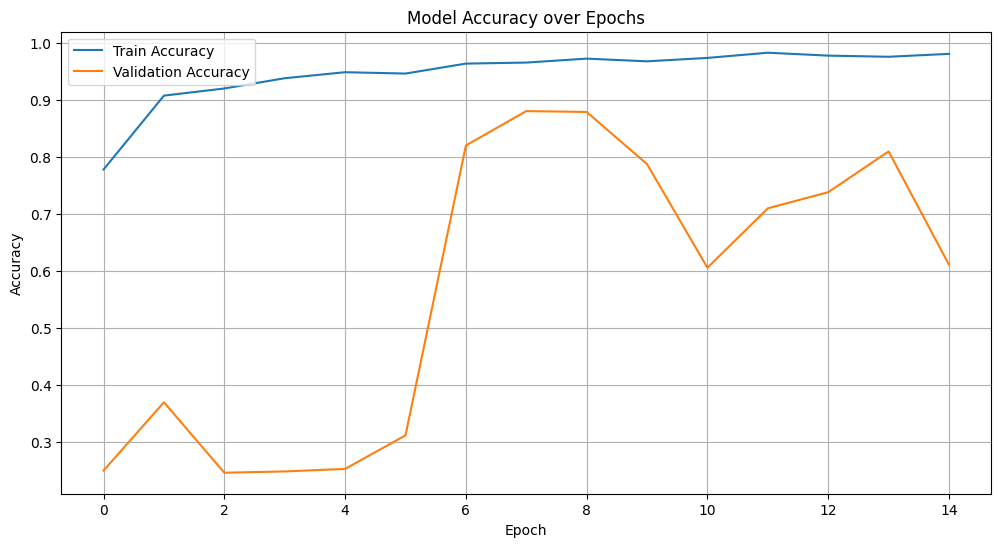

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 591ms/step - accuracy: 0.9807 - loss: 0.0585 - val_accuracy: 0.6109 - val_loss: 1.9555
Epoch 16/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9800 - loss: 0.0511

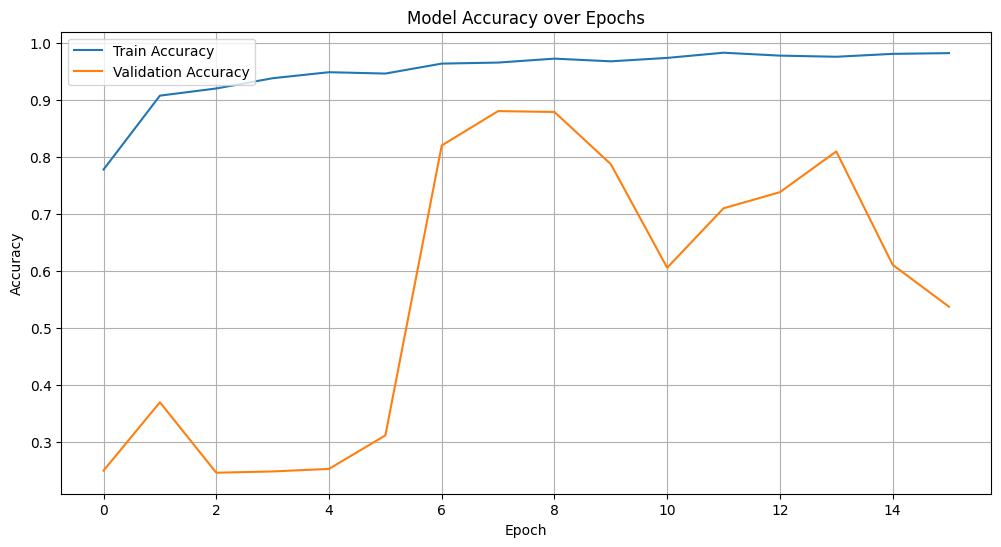

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 600ms/step - accuracy: 0.9800 - loss: 0.0511 - val_accuracy: 0.5372 - val_loss: 3.0921
Epoch 17/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9831 - loss: 0.0473

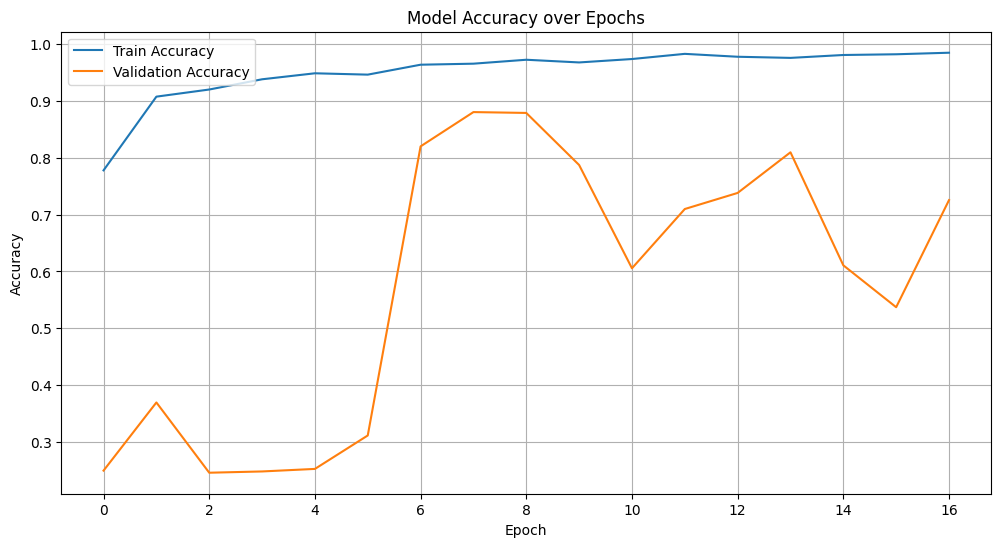

86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 596ms/step - accuracy: 0.9832 - loss: 0.0472 - val_accuracy: 0.7254 - val_loss: 1.0051
Epoch 18/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9834 - loss: 0.0497

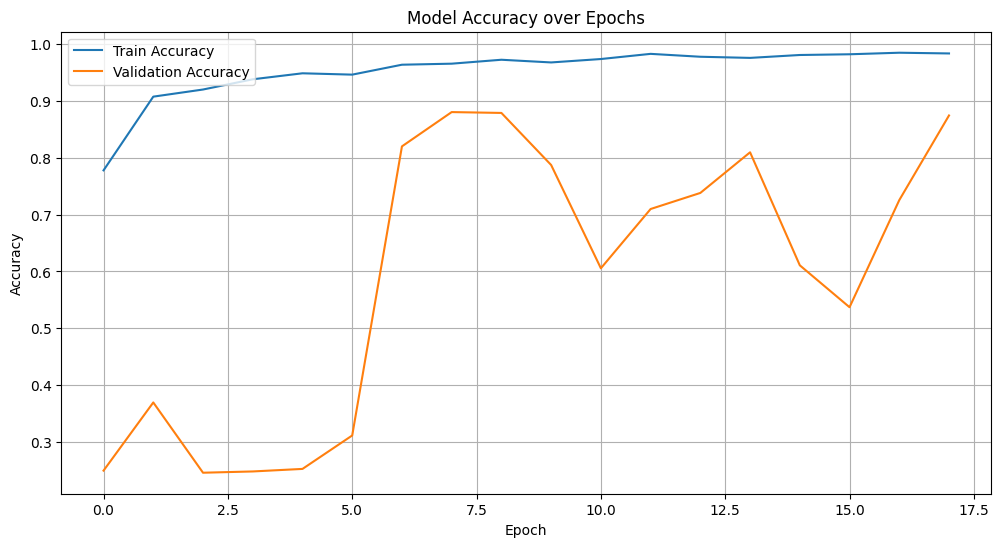

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 591ms/step - accuracy: 0.9834 - loss: 0.0497 - val_accuracy: 0.8743 - val_loss: 0.3792
Epoch 19/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9830 - loss: 0.0482

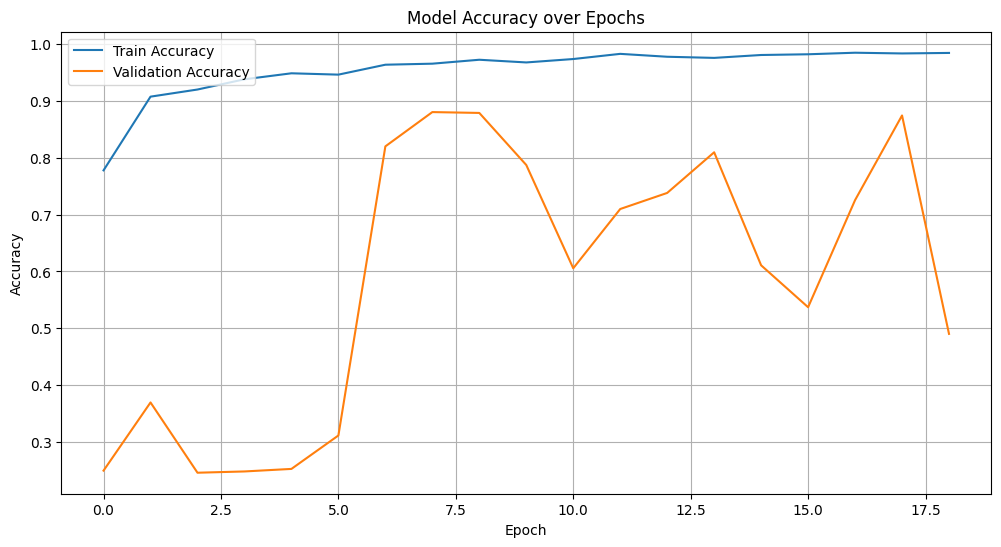

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 601ms/step - accuracy: 0.9830 - loss: 0.0482 - val_accuracy: 0.4903 - val_loss: 3.4582
Epoch 20/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9807 - loss: 0.0570

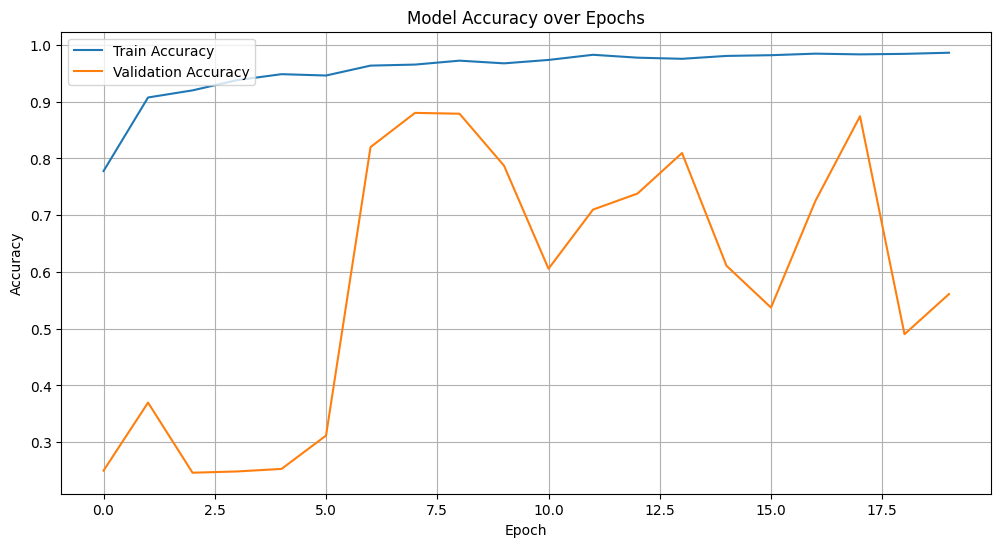

86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 605ms/step - accuracy: 0.9808 - loss: 0.0568 - val_accuracy: 0.5610 - val_loss: 2.1199
Epoch 21/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9822 - loss: 0.0567

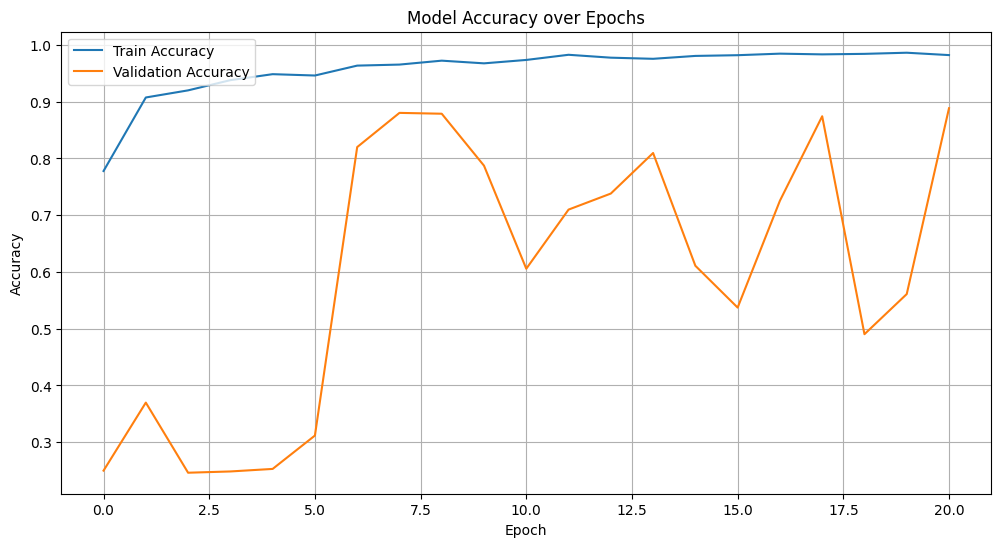

86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 611ms/step - accuracy: 0.9822 - loss: 0.0567 - val_accuracy: 0.8884 - val_loss: 0.3439
Epoch 22/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9852 - loss: 0.0454

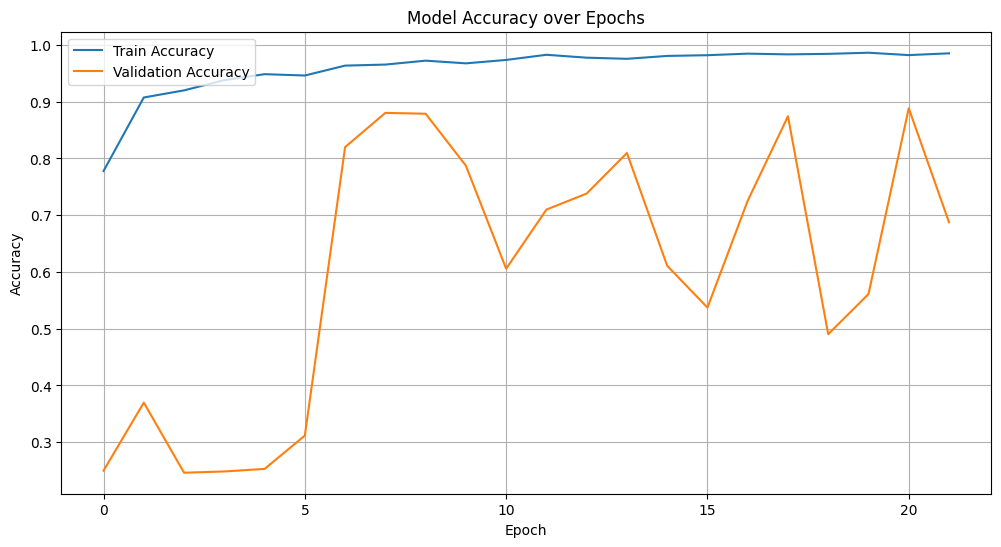

86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 600ms/step - accuracy: 0.9852 - loss: 0.0454 - val_accuracy: 0.6875 - val_loss: 3.2297
Epoch 23/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9841 - loss: 0.0462

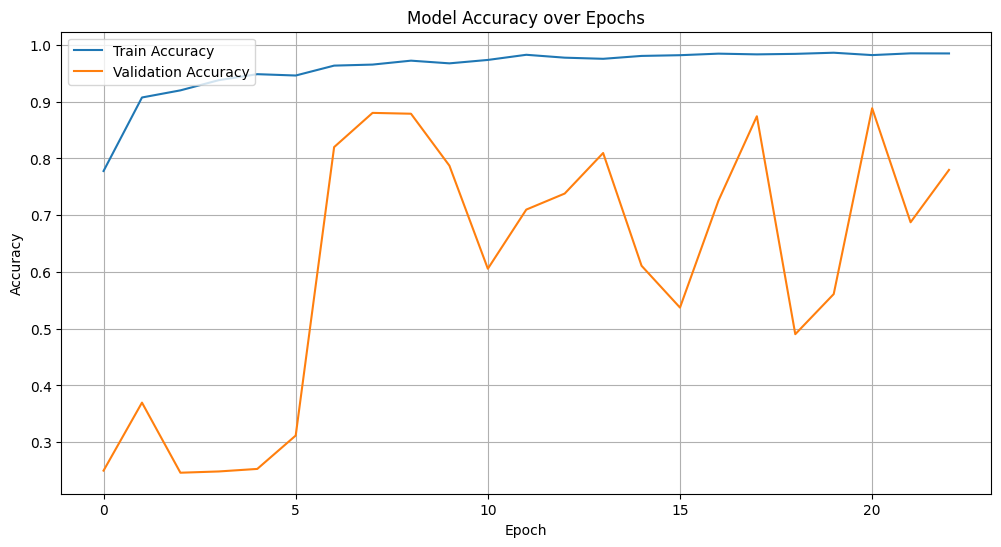

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 601ms/step - accuracy: 0.9841 - loss: 0.0462 - val_accuracy: 0.7798 - val_loss: 0.9883
Epoch 24/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9857 - loss: 0.0331

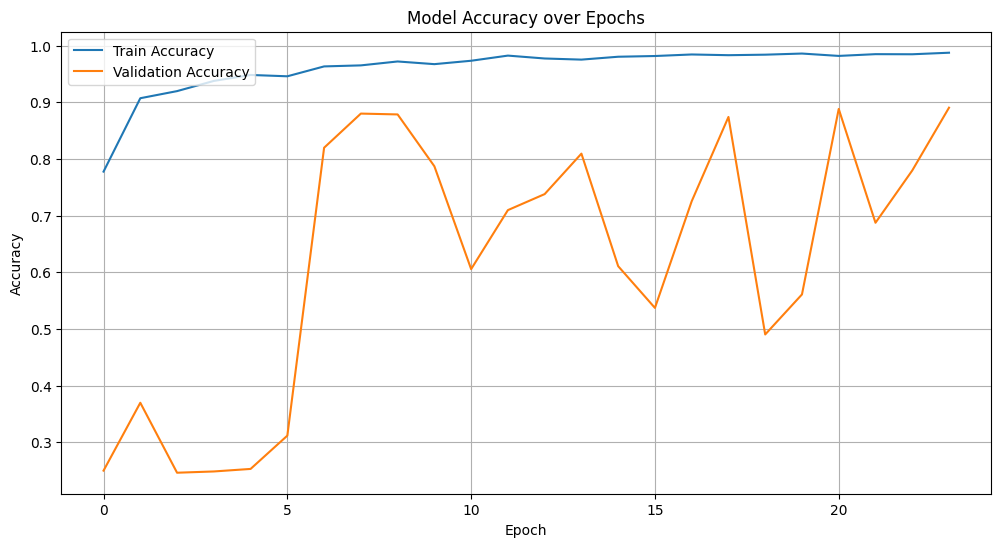

86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 612ms/step - accuracy: 0.9857 - loss: 0.0331 - val_accuracy: 0.8906 - val_loss: 0.2907
Epoch 25/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9828 - loss: 0.0514

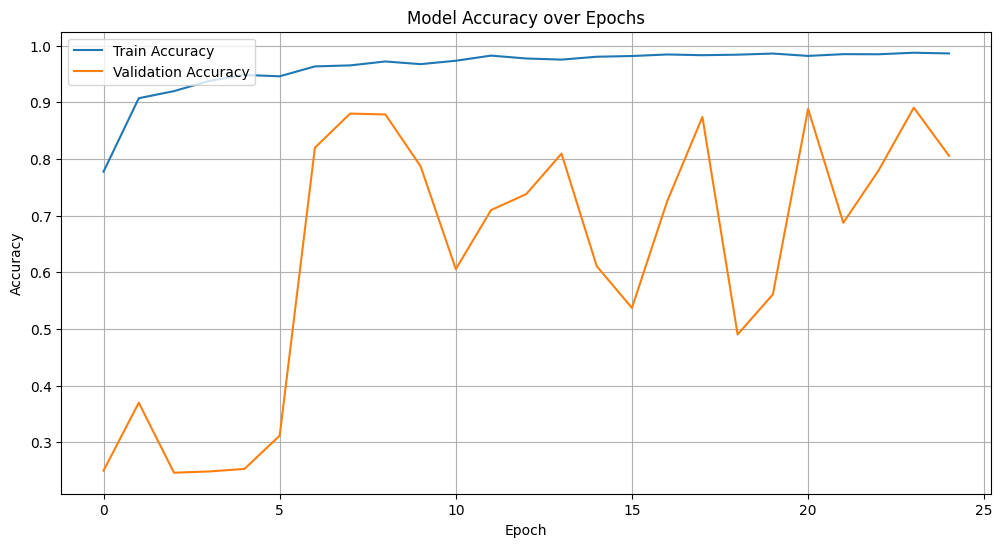

86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 599ms/step - accuracy: 0.9828 - loss: 0.0512 - val_accuracy: 0.8058 - val_loss: 0.6092
Epoch 26/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9863 - loss: 0.0432

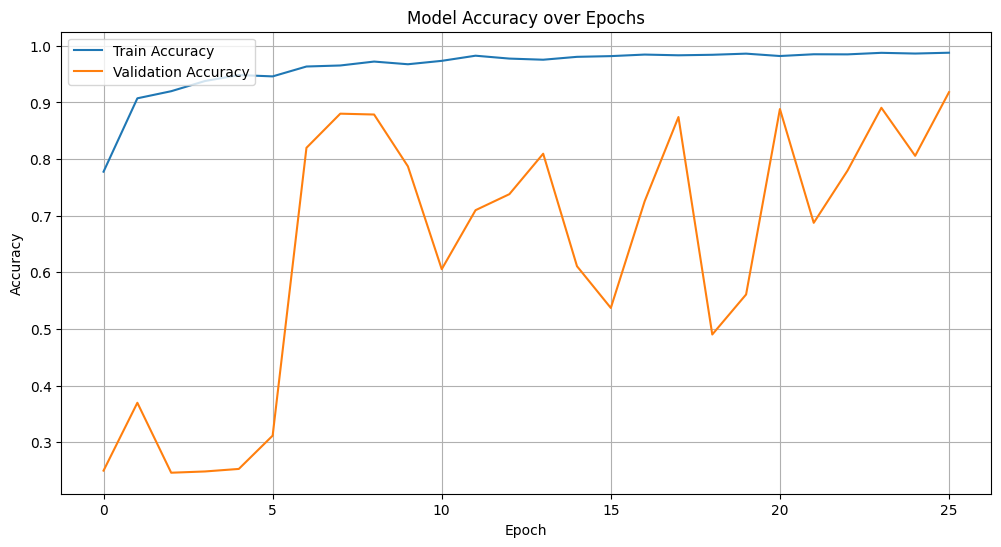

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 603ms/step - accuracy: 0.9863 - loss: 0.0431 - val_accuracy: 0.9182 - val_loss: 0.2344
Epoch 27/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9888 - loss: 0.0400

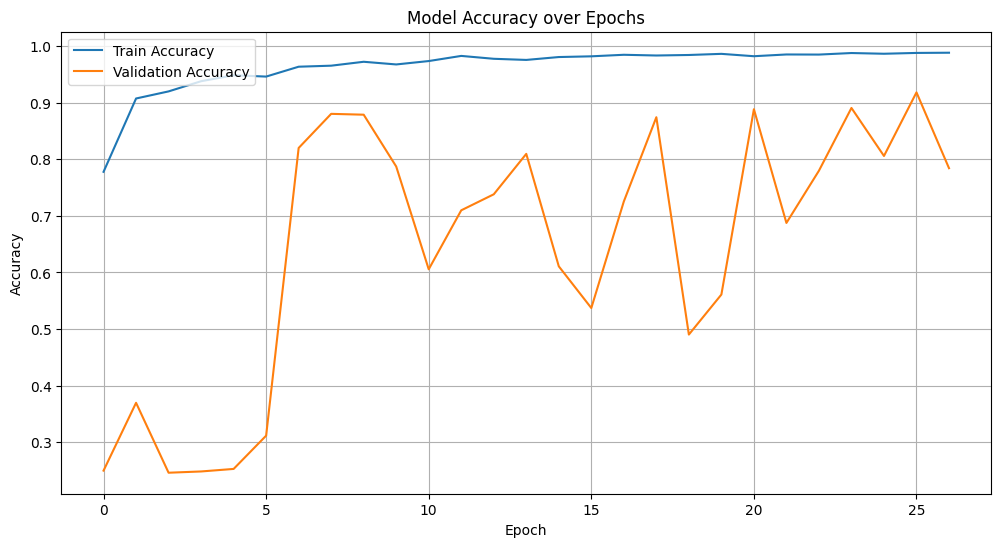

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 599ms/step - accuracy: 0.9888 - loss: 0.0400 - val_accuracy: 0.7842 - val_loss: 0.8938
Epoch 28/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9854 - loss: 0.0431

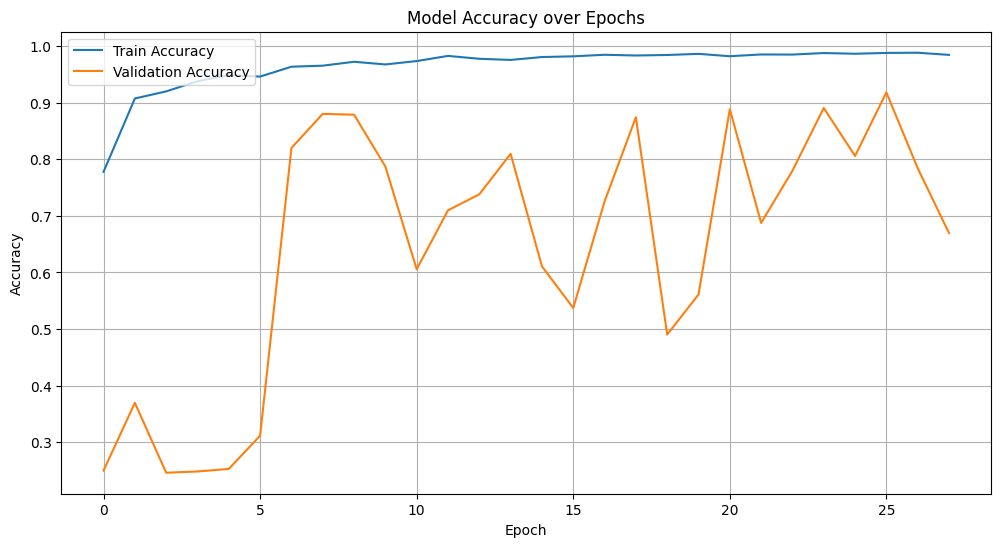

86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 593ms/step - accuracy: 0.9854 - loss: 0.0432 - val_accuracy: 0.6696 - val_loss: 1.1680
Epoch 29/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9884 - loss: 0.0357

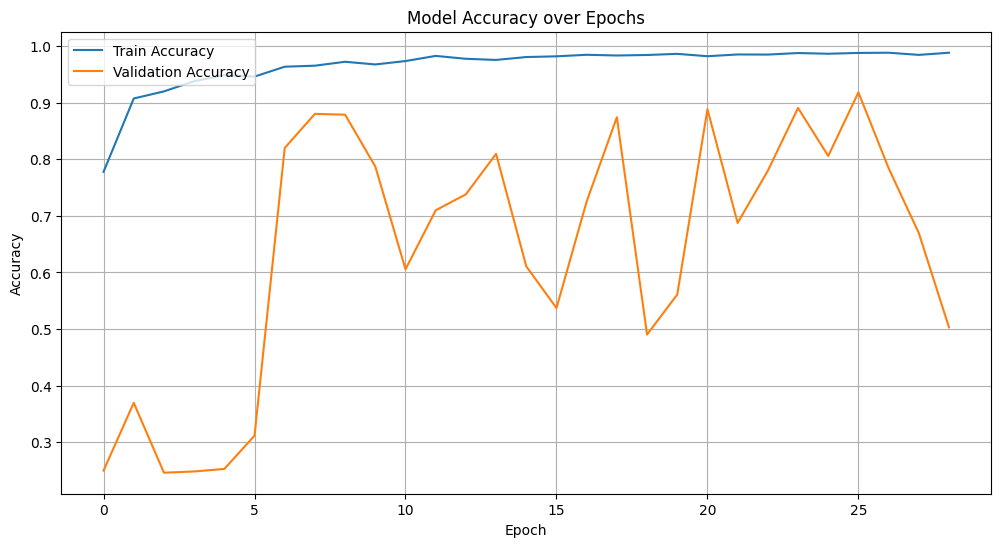

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 602ms/step - accuracy: 0.9884 - loss: 0.0357 - val_accuracy: 0.5030 - val_loss: 4.2137
Epoch 30/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9820 - loss: 0.0575

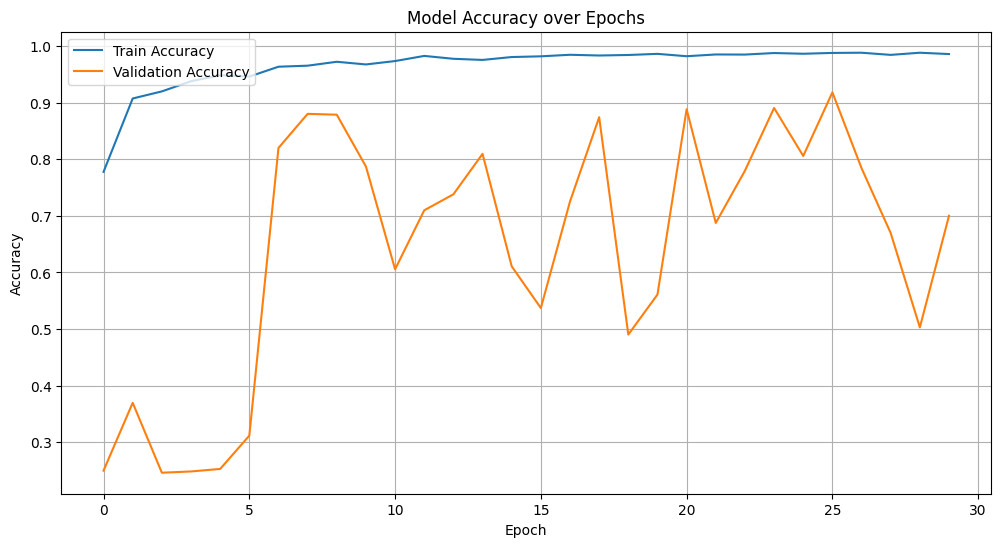

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 597ms/step - accuracy: 0.9820 - loss: 0.0573 - val_accuracy: 0.7001 - val_loss: 1.0332
Epoch 31/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9864 - loss: 0.0371

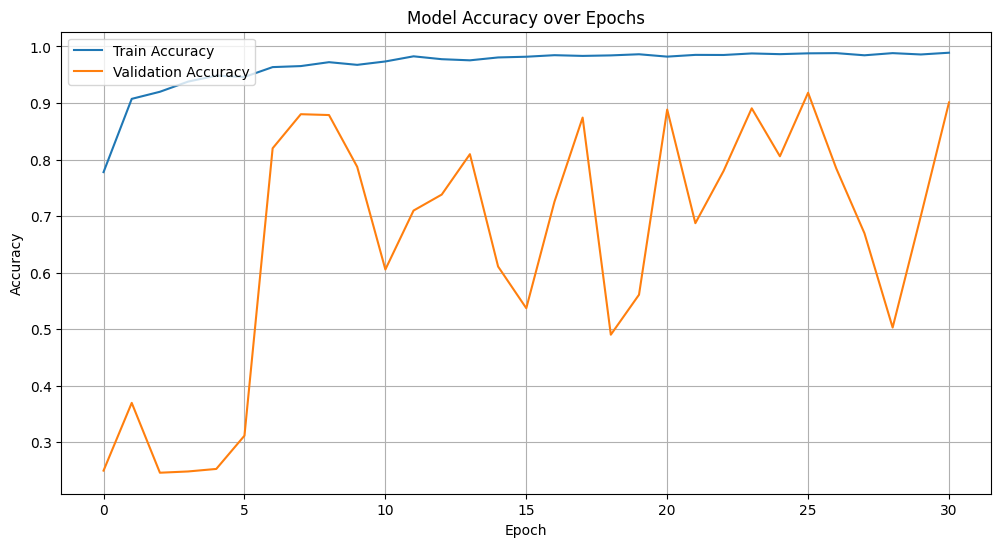

86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 607ms/step - accuracy: 0.9864 - loss: 0.0370 - val_accuracy: 0.9010 - val_loss: 0.3252
Epoch 32/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9854 - loss: 0.0431

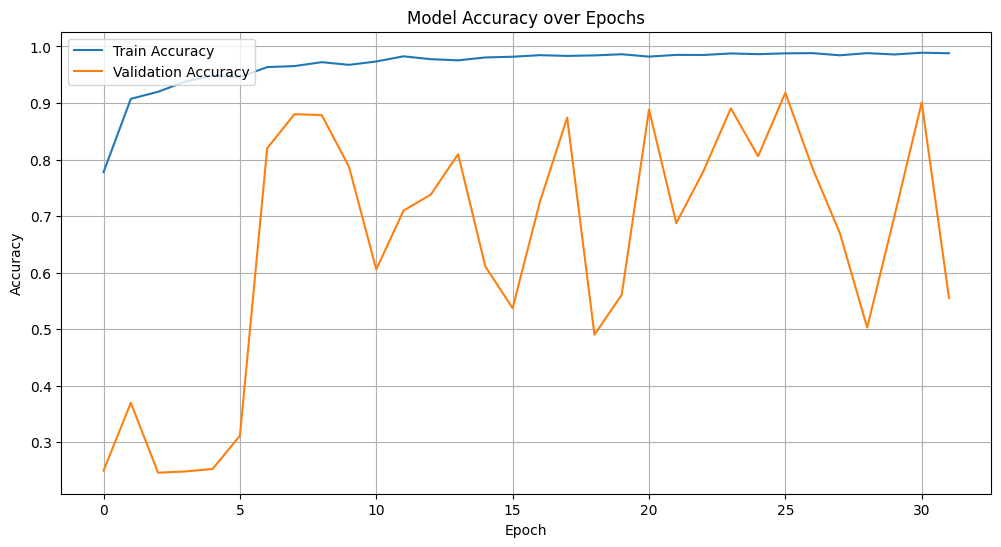

86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 603ms/step - accuracy: 0.9855 - loss: 0.0430 - val_accuracy: 0.5551 - val_loss: 2.8395
Epoch 33/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9880 - loss: 0.0403

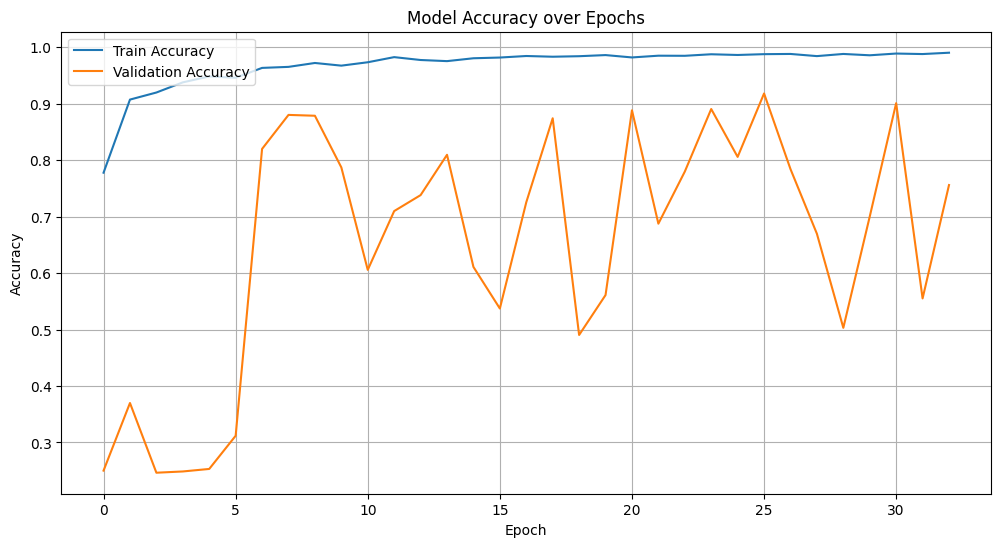

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 609ms/step - accuracy: 0.9880 - loss: 0.0402 - val_accuracy: 0.7560 - val_loss: 0.7256
Epoch 34/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9910 - loss: 0.0255

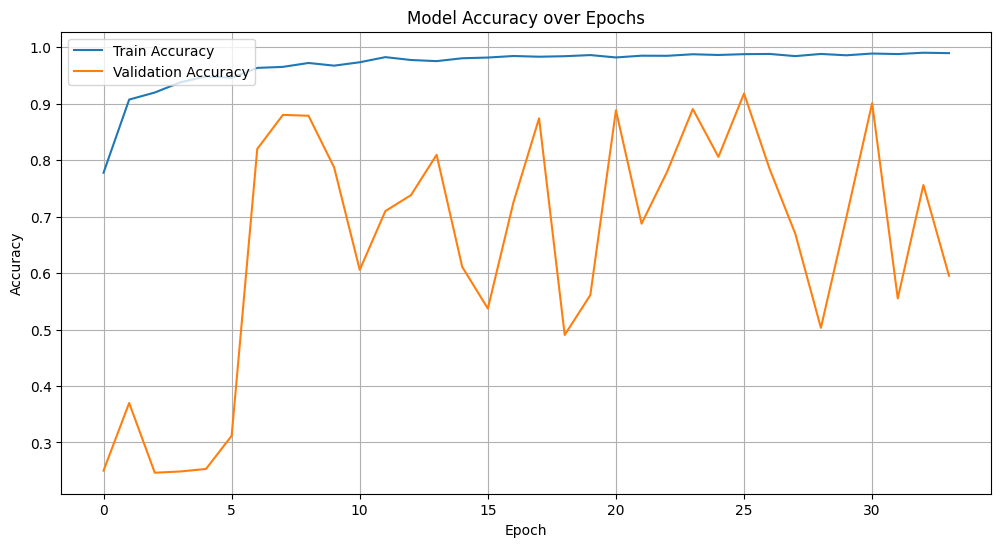

86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 618ms/step - accuracy: 0.9910 - loss: 0.0256 - val_accuracy: 0.5952 - val_loss: 3.4088
Epoch 35/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9912 - loss: 0.0247

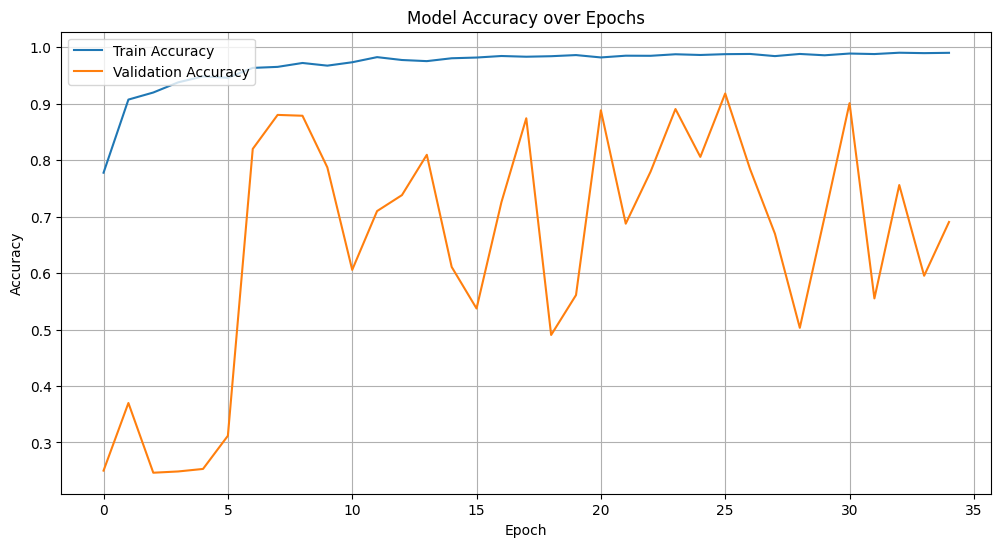

86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 611ms/step - accuracy: 0.9912 - loss: 0.0247 - val_accuracy: 0.6905 - val_loss: 2.0117
Epoch 36/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9898 - loss: 0.0268

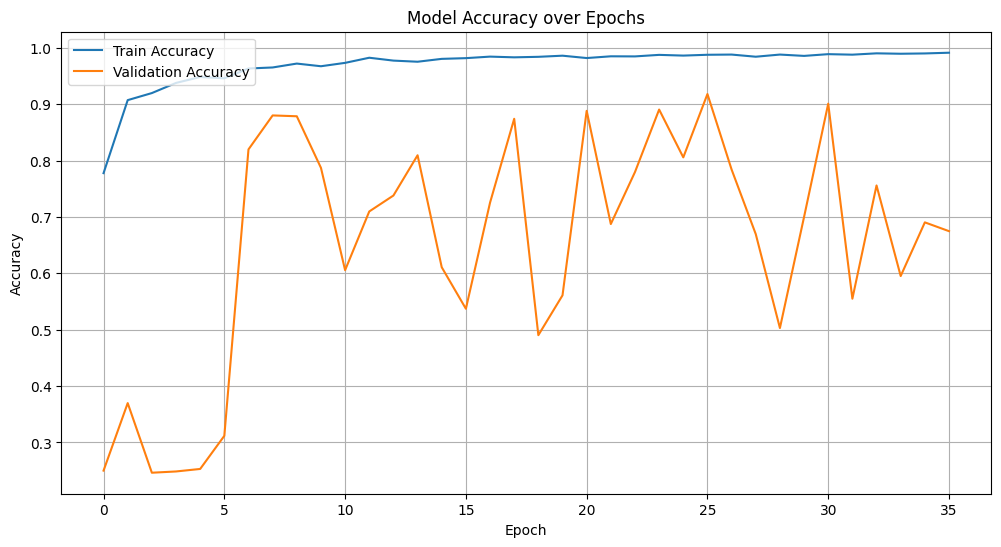

86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 609ms/step - accuracy: 0.9898 - loss: 0.0268 - val_accuracy: 0.6749 - val_loss: 0.8158
Epoch 37/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9904 - loss: 0.0270

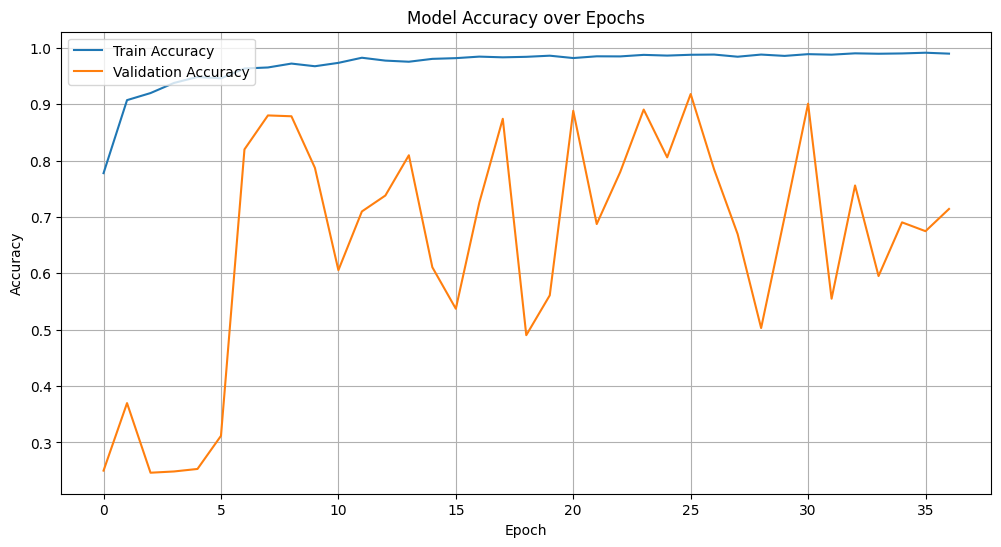

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 599ms/step - accuracy: 0.9904 - loss: 0.0270 - val_accuracy: 0.7143 - val_loss: 1.6126
Epoch 38/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9874 - loss: 0.0298

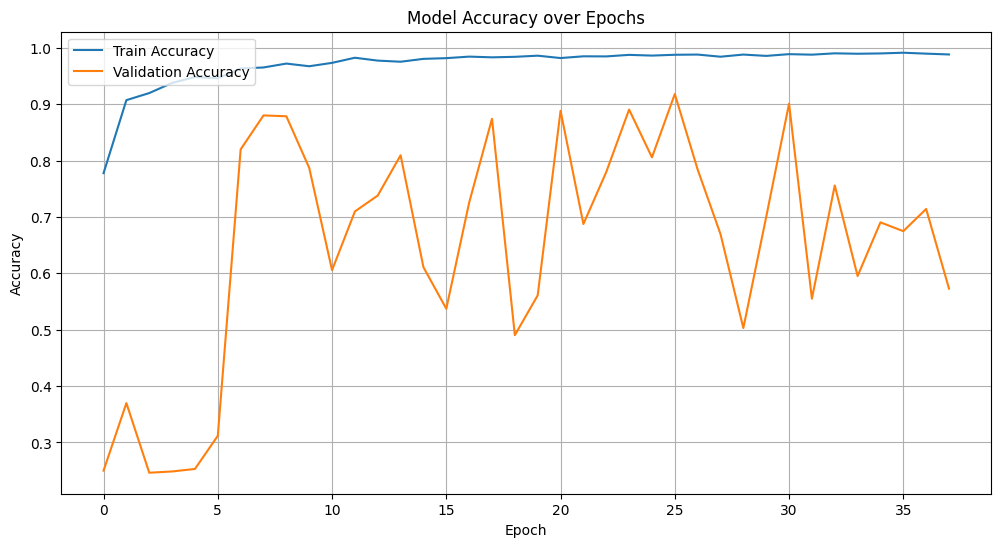

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 599ms/step - accuracy: 0.9874 - loss: 0.0298 - val_accuracy: 0.5729 - val_loss: 1.7895
Epoch 39/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9917 - loss: 0.0253

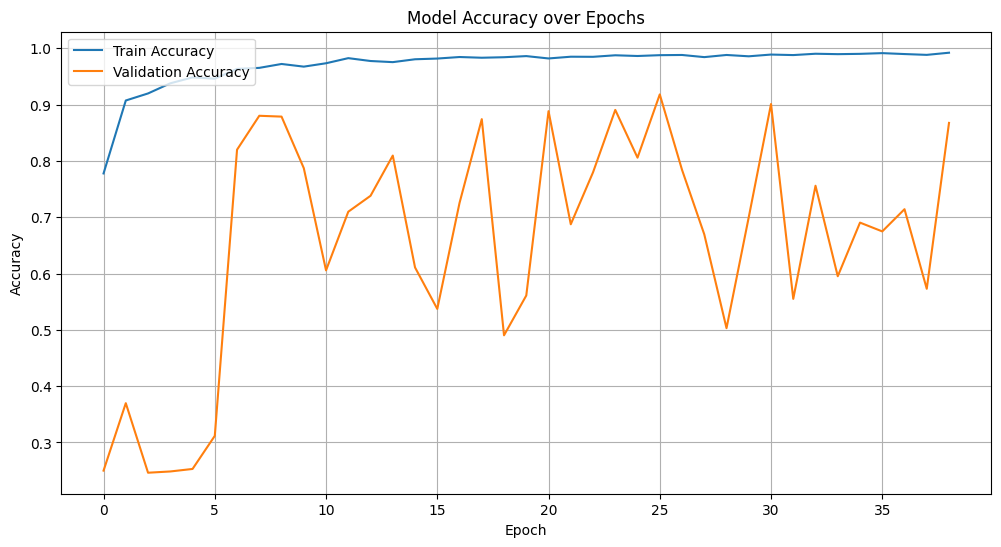

86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 615ms/step - accuracy: 0.9918 - loss: 0.0252 - val_accuracy: 0.8676 - val_loss: 0.5115
Epoch 40/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9921 - loss: 0.0245

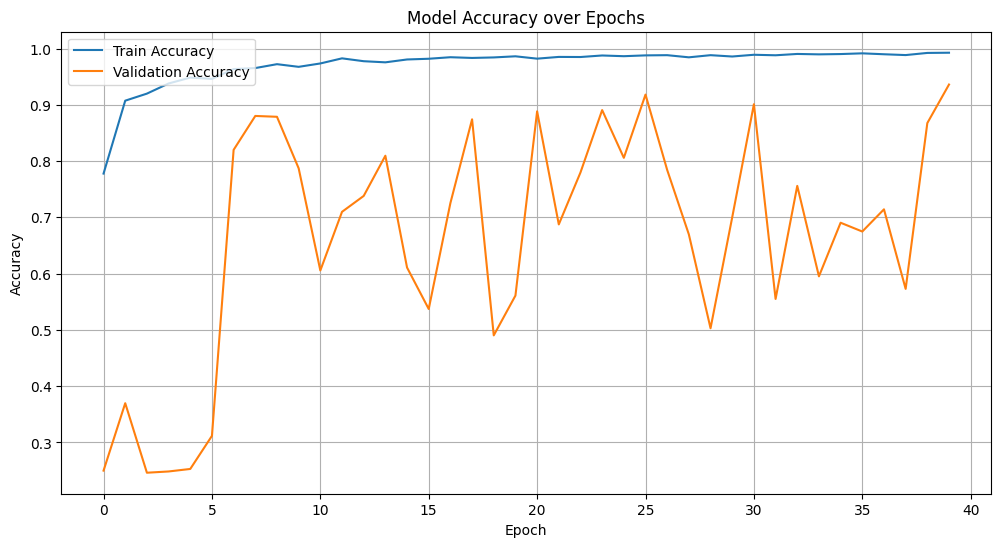

86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 599ms/step - accuracy: 0.9921 - loss: 0.0245 - val_accuracy: 0.9360 - val_loss: 0.1668


In [ ]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3) # 1 channel means for grayscale / 3 for RGB
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40 # @param {"type":"slider","min":10,"max":100,"step":1}
plot_metrics = PlotMetrics()
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[plot_metrics])


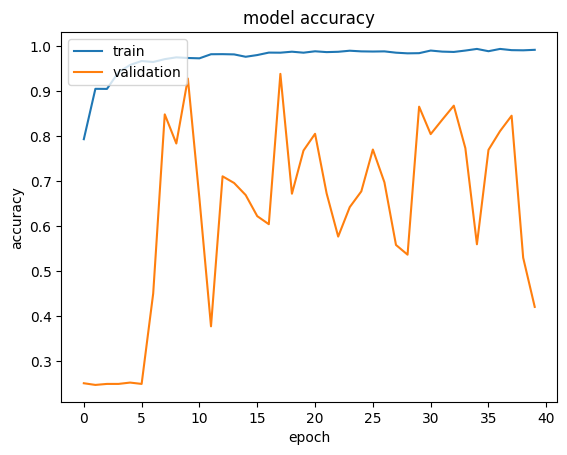

In [ ]:
plot_hist(hist)

In [ ]:
model.save('/content/drive/Shareddrives/FYP/model/efficientnetb0_model_0204.h5')  # Save in HDF5 format or use the SavedModel format

print("Model saved as 'efficientnetb0_model.h5'")

Model saved as 'efficientnetb0_model.h5'


In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/Shareddrives/FYP/model/efficientnetb0_model_0204.h5'
model = load_model(model_path)
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Assuming you have loaded your test dataset with both input data and labels
test_loss, test_accuracy = model.evaluate(ds_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.9902 - loss: 0.0546
Test Loss: 0.04979810118675232
Test Accuracy: 0.9911684989929199


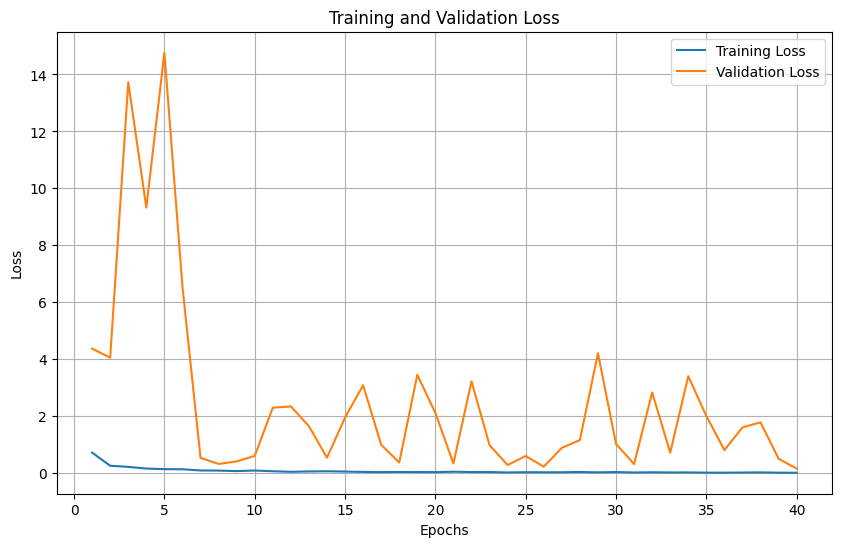

In [ ]:
import matplotlib.pyplot as plt

# Define the training and validation loss values obtained during training
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
epochs = range(1, len(training_loss) + 1)  # Number of epochs

# Plot the training and validation loss over the number of epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Found 5560 files belonging to 4 classes.
Labels shape: (5560,)


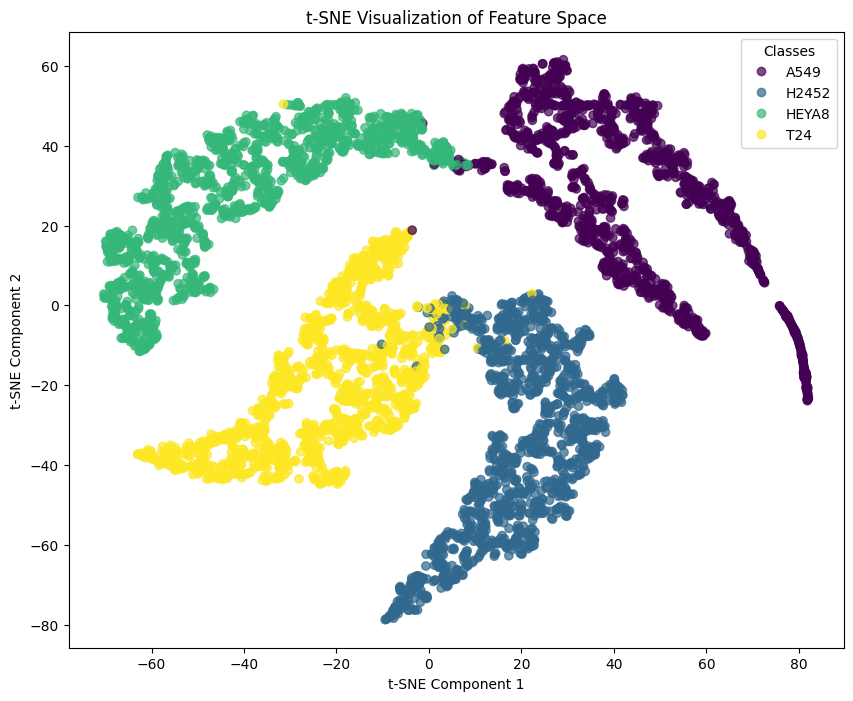

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
import tensorflow as tf

# Define constants
IMG_SIZE = 224  # Adjust based on your model's input size
NUM_CLASSES = 4  # Specify the number of classes


# Create a feature extractor model
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Load the dataset as grayscale
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/Shareddrives/FYP/single_cell_data/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    color_mode='grayscale'
)

# Step 1: Extract features from the model
features = []
labels = []

for images, label in ds_train:
    # Extract features
    feature_batch = feature_extractor(images).numpy()
    features.append(feature_batch)
    labels.append(label.numpy())

# Concatenate all features and labels
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Check the shape of the labels
print("Labels shape:", labels.shape)

# Ensure labels are in the correct format for t-SNE
if len(labels.shape) == 1:  # If labels are one-dimensional
    labels = np.eye(NUM_CLASSES)[labels]  # Convert to one-hot encoding

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)


class_names = {
    0: 'A549',
    1: 'H2452',
    2: 'HEYA8',
    3: 'T24'
}

# Step 3: Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.argmax(labels, axis=1), cmap='viridis', alpha=0.7)
# plt.colorbar(scatter)
handles, _ = scatter.legend_elements()
custom_labels = [class_names[label] for label in np.unique(np.argmax(labels, axis=1))]
plt.legend(handles, custom_labels, title='Classes', loc='best')

plt.title('t-SNE Visualization of Feature Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

# The best transfer learning model

In [ ]:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6733 - loss: 0.8399 

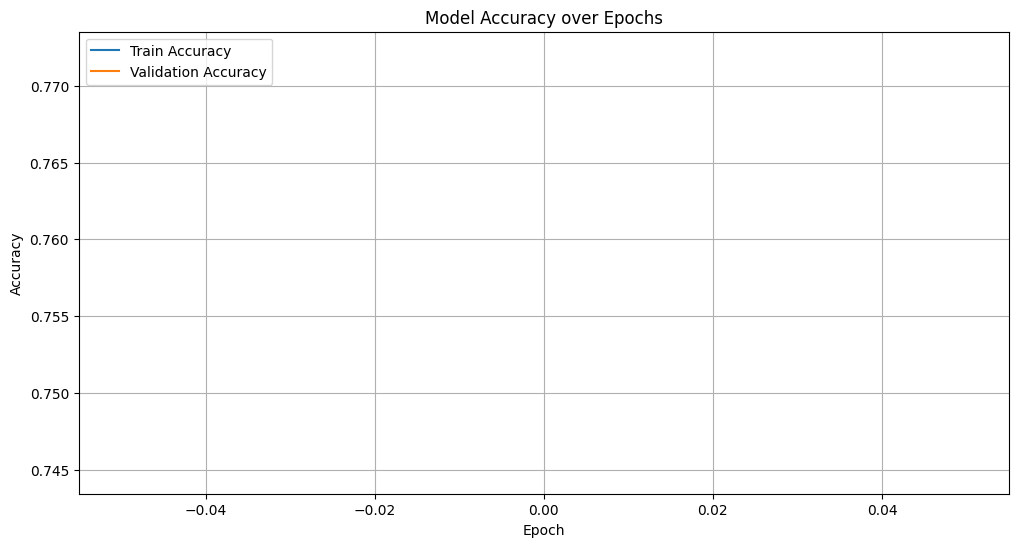

86/86 ━━━━━━━━━━━━━━━━━━━━ 1784s 20s/step - accuracy: 0.6745 - loss: 0.8370 - val_accuracy: 0.7448 - val_loss: 0.8033
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8820 - loss: 0.3273

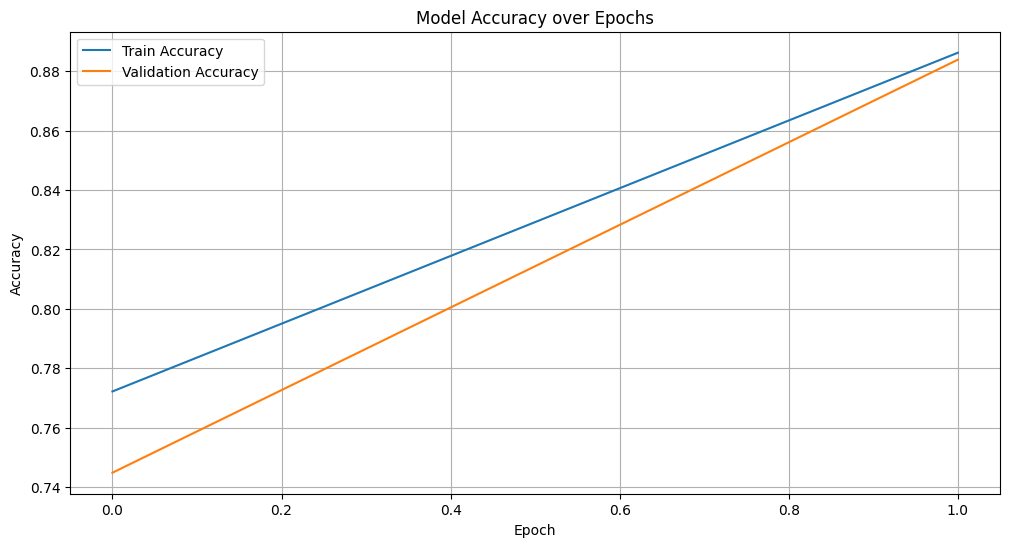

86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 864ms/step - accuracy: 0.8820 - loss: 0.3272 - val_accuracy: 0.8839 - val_loss: 0.5185
Epoch 3/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8989 - loss: 0.2720

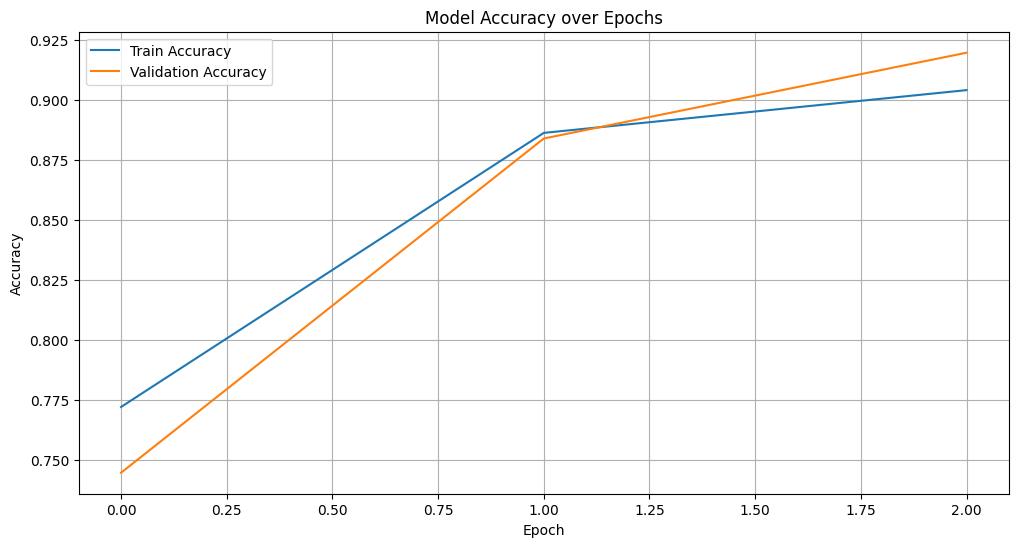

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 495ms/step - accuracy: 0.8990 - loss: 0.2719 - val_accuracy: 0.9196 - val_loss: 0.3585
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9073 - loss: 0.2458

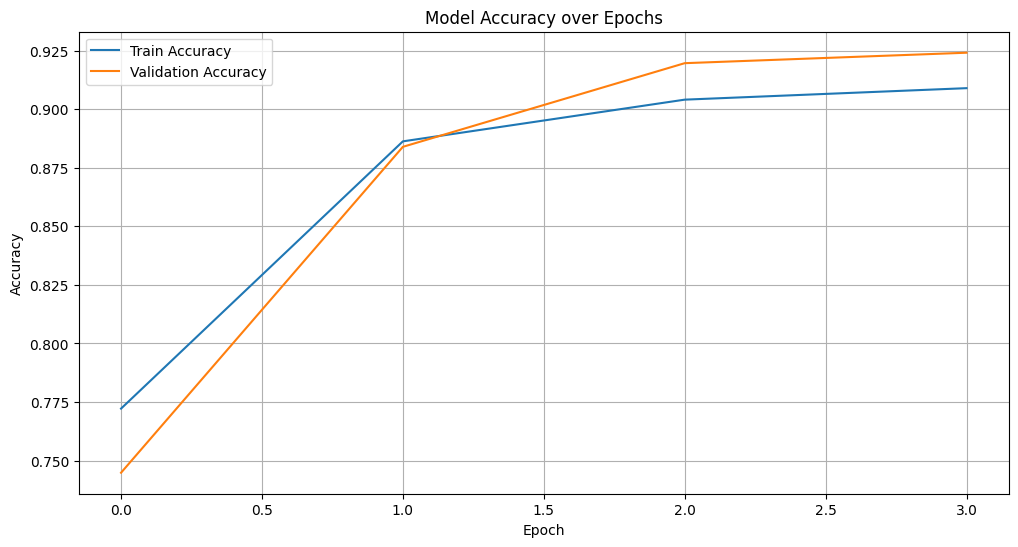

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.9073 - loss: 0.2457 - val_accuracy: 0.9241 - val_loss: 0.2769
Epoch 5/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9223 - loss: 0.2102

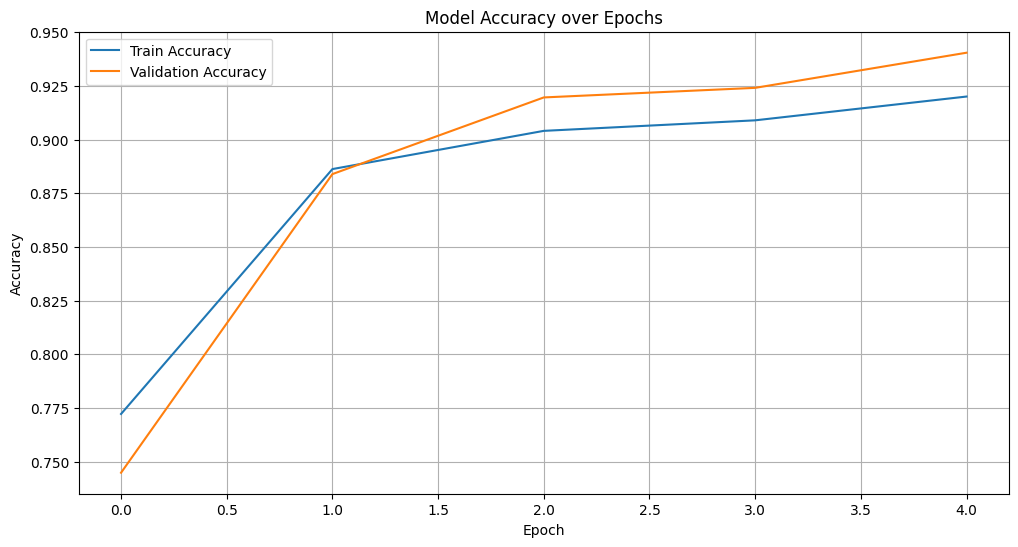

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9223 - loss: 0.2102 - val_accuracy: 0.9405 - val_loss: 0.2150
Epoch 6/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9262 - loss: 0.2010

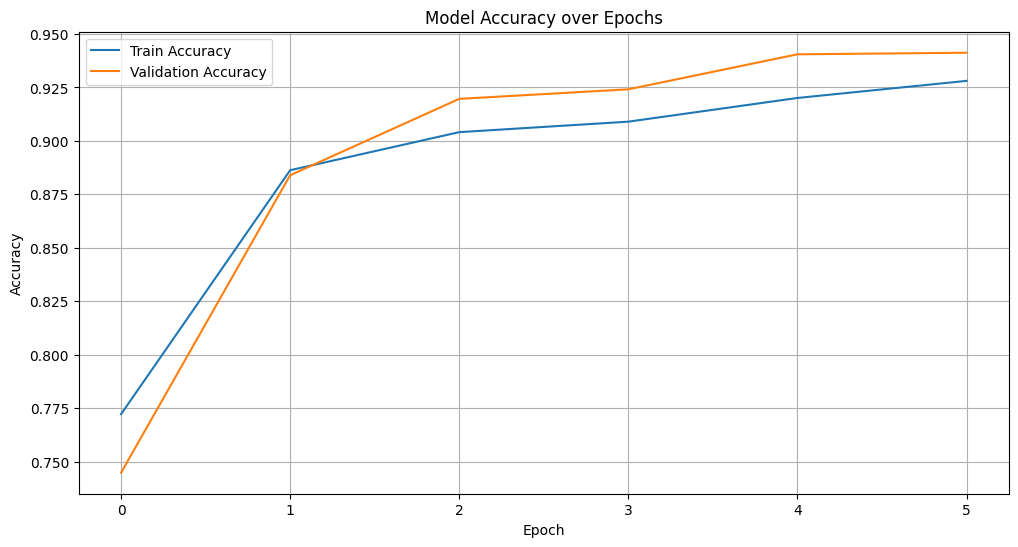

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 449ms/step - accuracy: 0.9262 - loss: 0.2009 - val_accuracy: 0.9412 - val_loss: 0.1844
Epoch 7/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9274 - loss: 0.2218

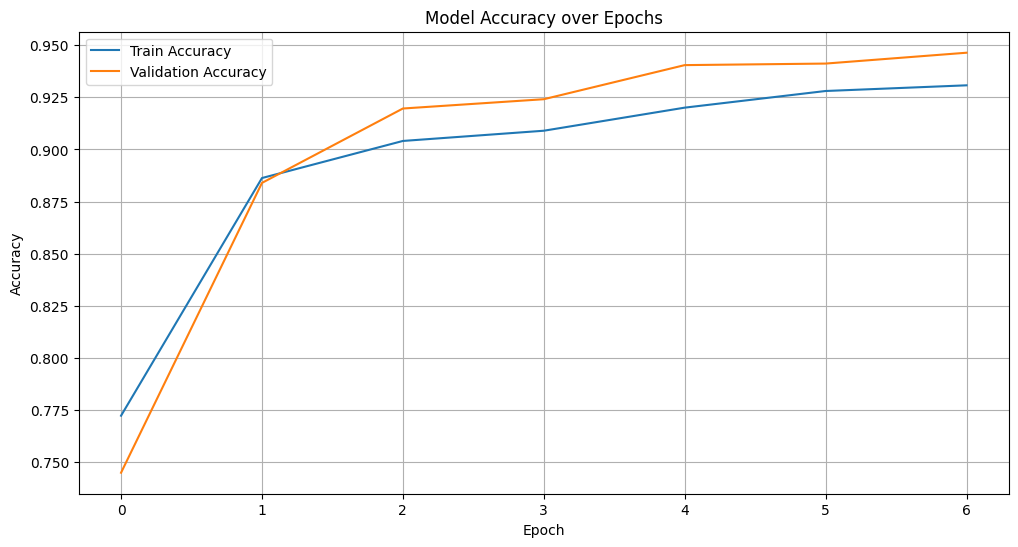

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 449ms/step - accuracy: 0.9275 - loss: 0.2216 - val_accuracy: 0.9464 - val_loss: 0.1716
Epoch 8/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9319 - loss: 0.1867

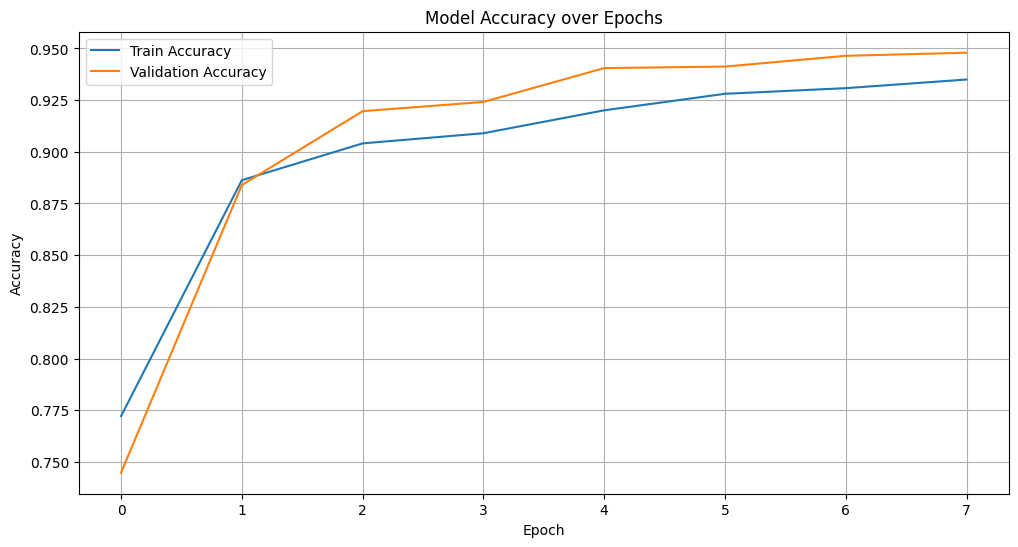

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.9319 - loss: 0.1867 - val_accuracy: 0.9479 - val_loss: 0.1557
Epoch 9/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9379 - loss: 0.1686

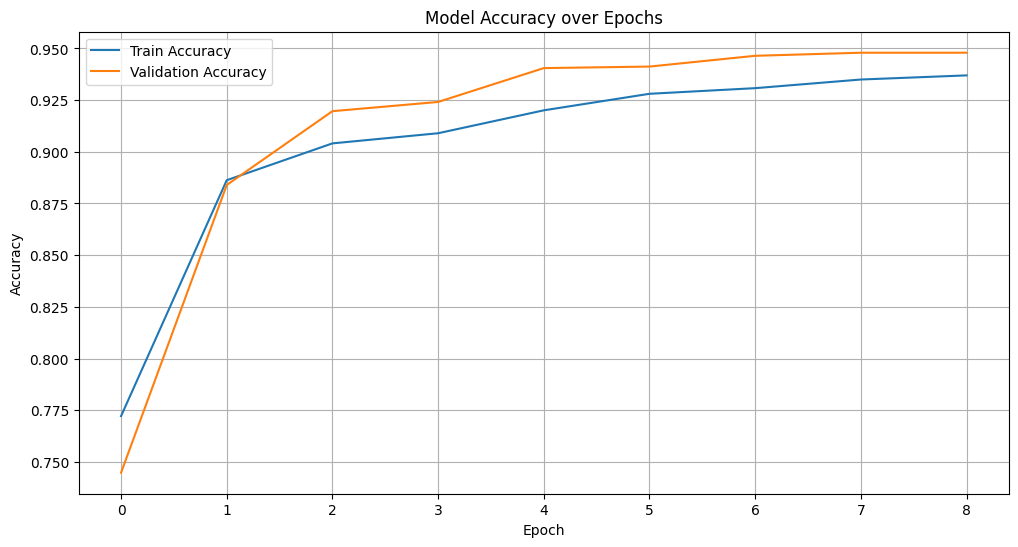

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 463ms/step - accuracy: 0.9379 - loss: 0.1687 - val_accuracy: 0.9479 - val_loss: 0.1428
Epoch 10/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9335 - loss: 0.1755

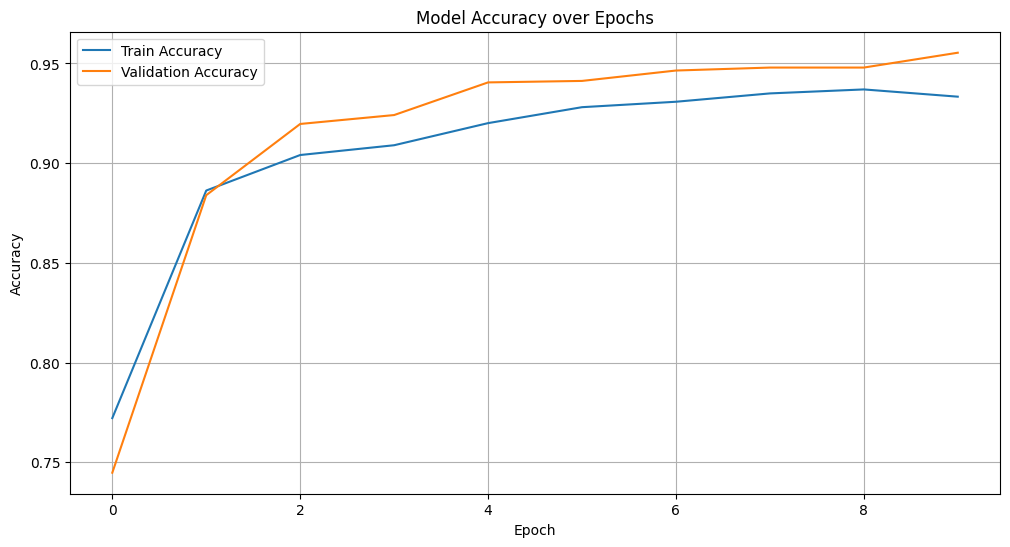

86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - accuracy: 0.9335 - loss: 0.1756 - val_accuracy: 0.9554 - val_loss: 0.1345
Epoch 11/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9334 - loss: 0.1841

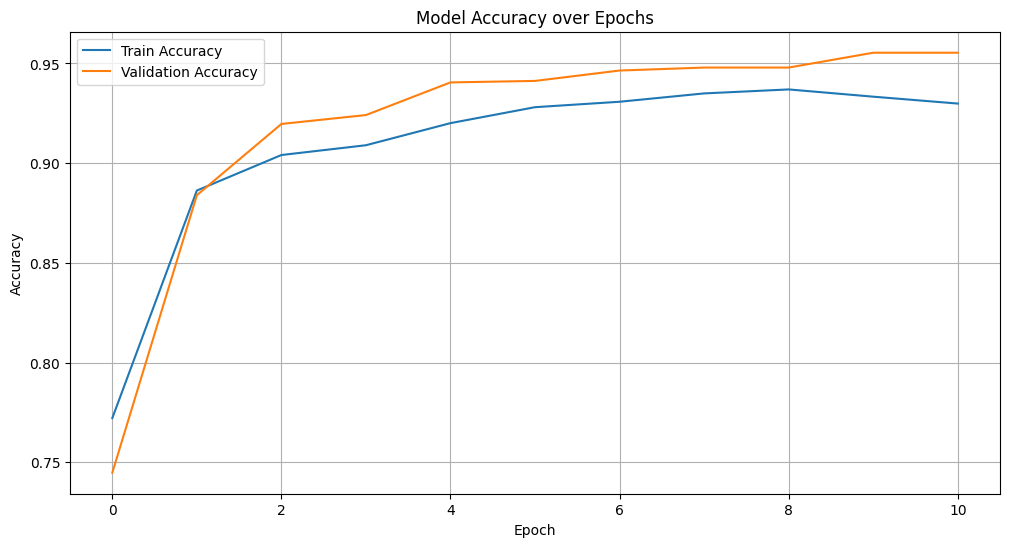

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - accuracy: 0.9334 - loss: 0.1842 - val_accuracy: 0.9554 - val_loss: 0.1293
Epoch 12/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9396 - loss: 0.1760

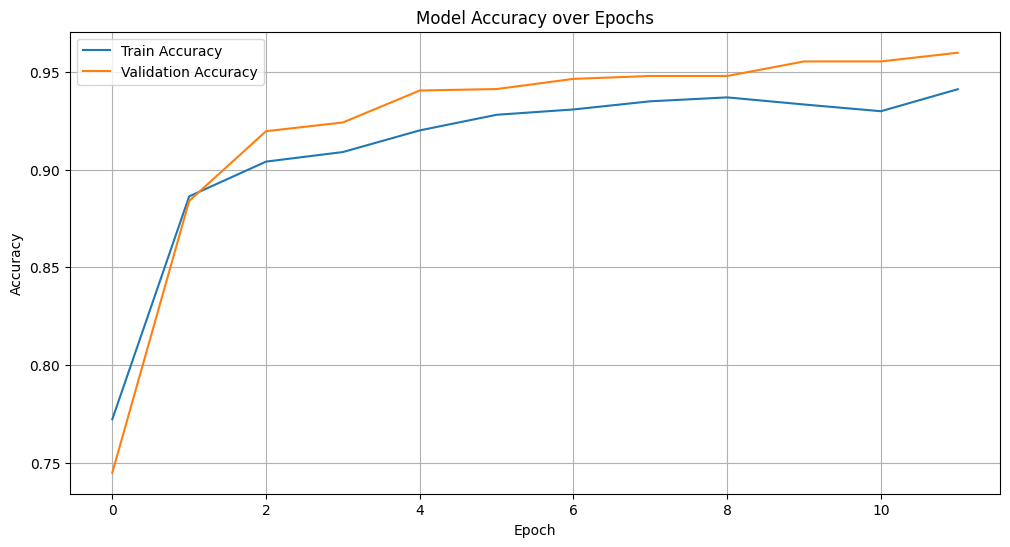

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9396 - loss: 0.1759 - val_accuracy: 0.9598 - val_loss: 0.1270
Epoch 13/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9342 - loss: 0.1795

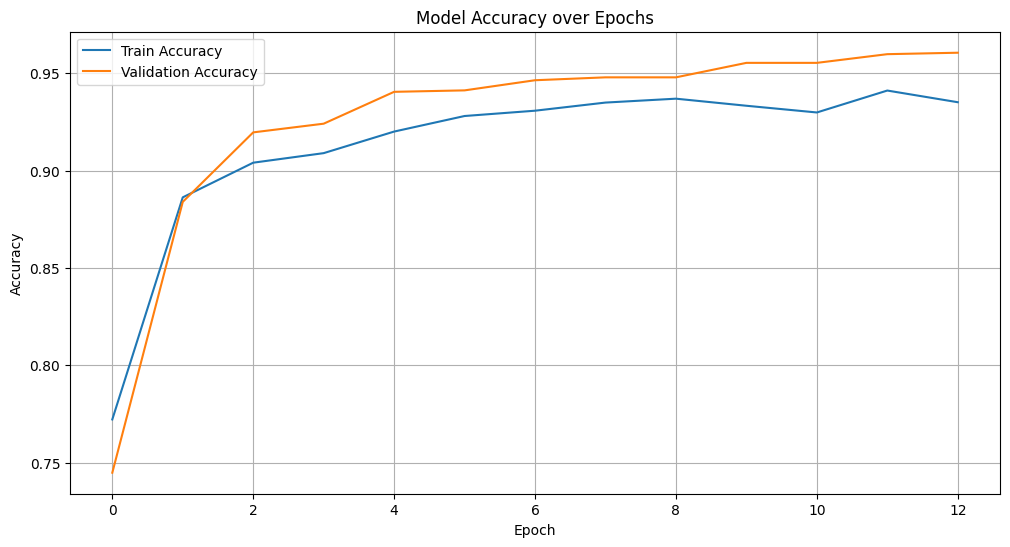

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.9342 - loss: 0.1795 - val_accuracy: 0.9606 - val_loss: 0.1204
Epoch 14/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9429 - loss: 0.1536

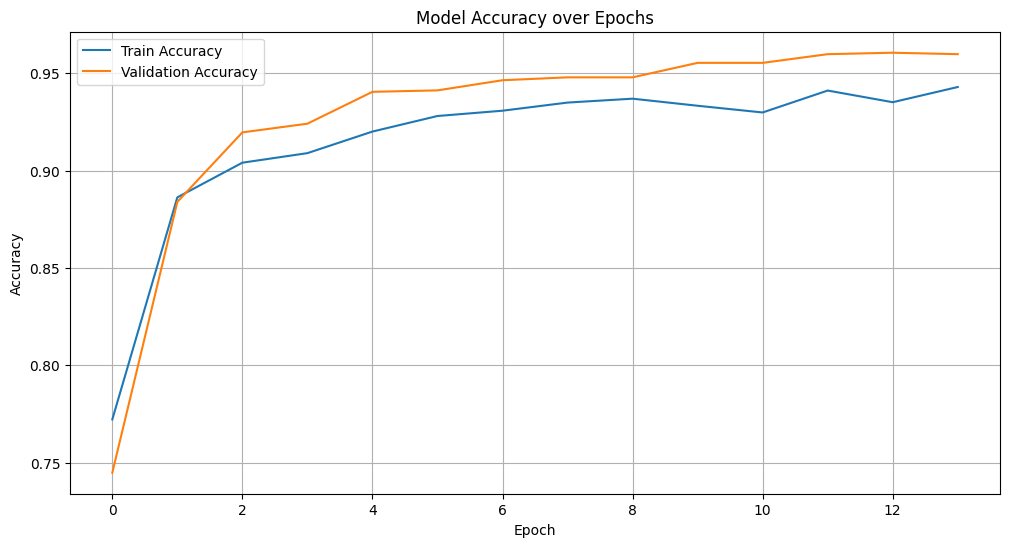

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.9429 - loss: 0.1536 - val_accuracy: 0.9598 - val_loss: 0.1218
Epoch 15/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9412 - loss: 0.1628

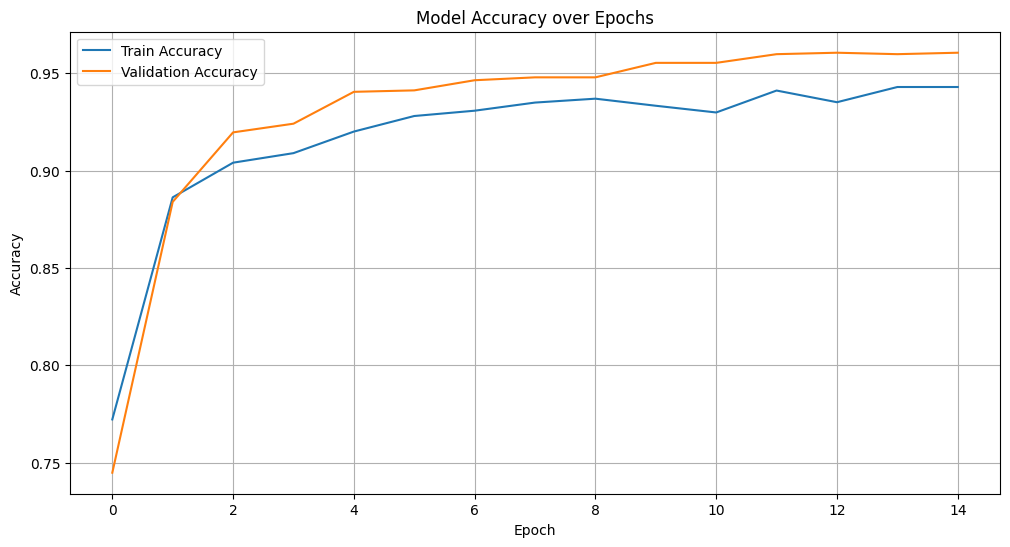

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9412 - loss: 0.1627 - val_accuracy: 0.9606 - val_loss: 0.1195
Epoch 16/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9465 - loss: 0.1573

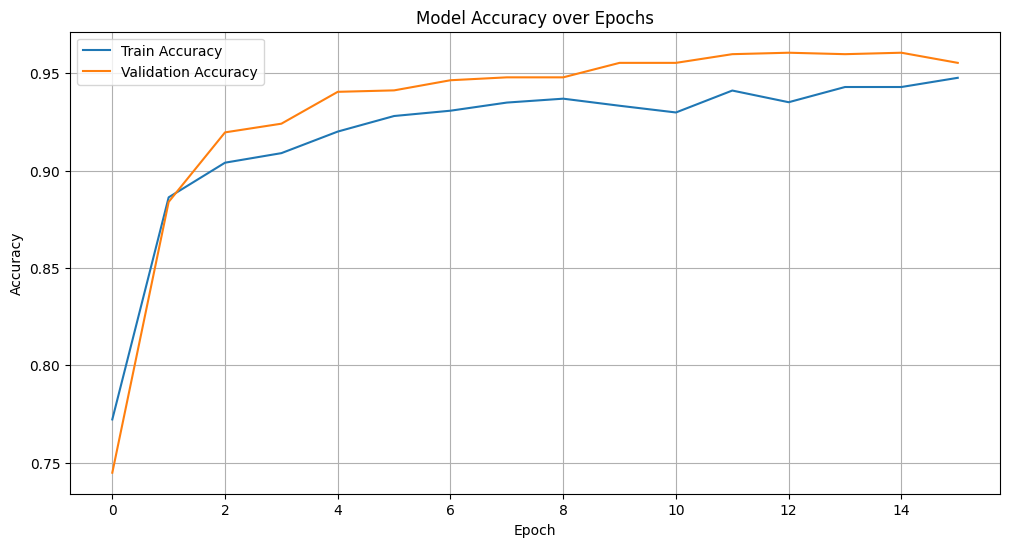

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - accuracy: 0.9465 - loss: 0.1572 - val_accuracy: 0.9554 - val_loss: 0.1191
Epoch 17/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9473 - loss: 0.1497

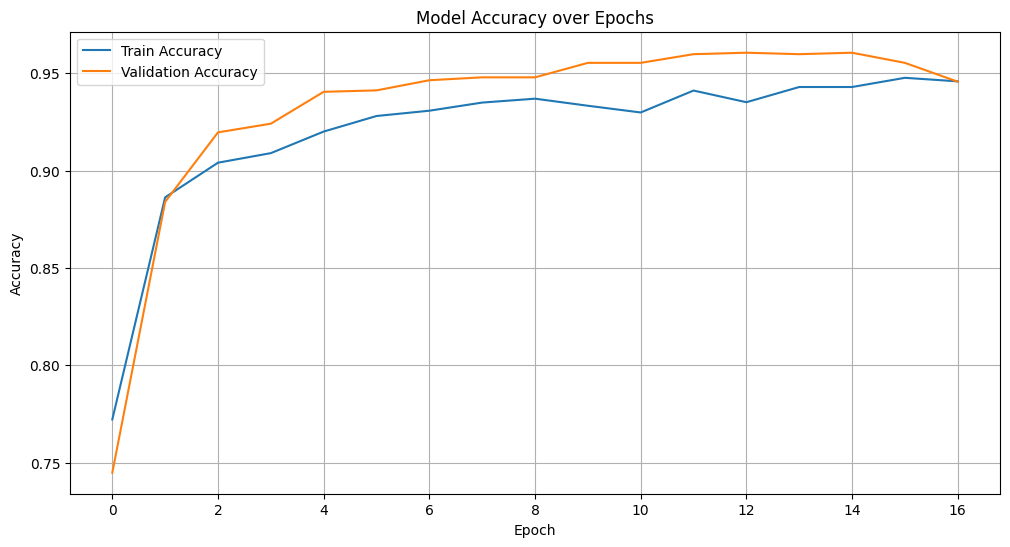

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 443ms/step - accuracy: 0.9472 - loss: 0.1497 - val_accuracy: 0.9457 - val_loss: 0.1439
Epoch 18/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9397 - loss: 0.1610

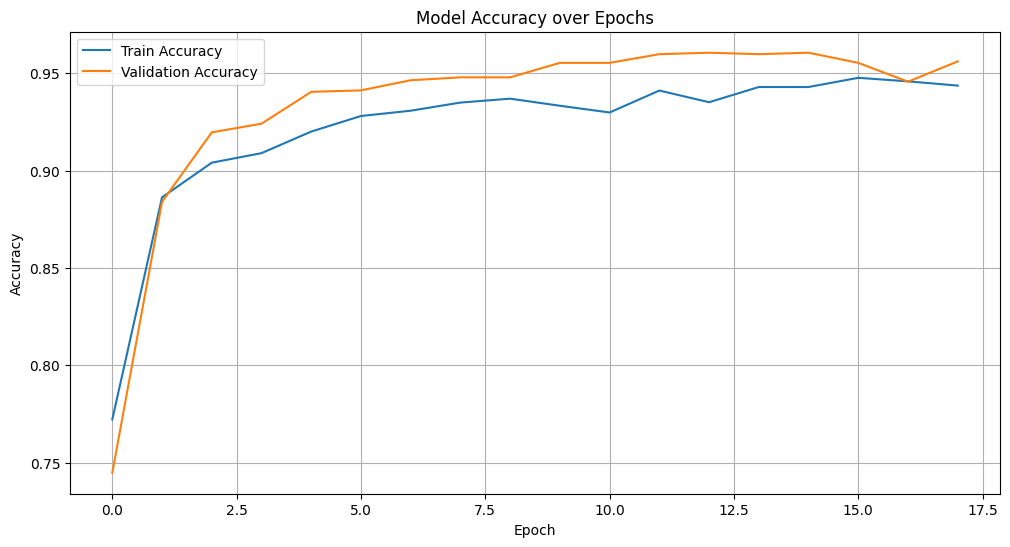

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 448ms/step - accuracy: 0.9397 - loss: 0.1610 - val_accuracy: 0.9561 - val_loss: 0.1233
Epoch 19/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9375 - loss: 0.1664

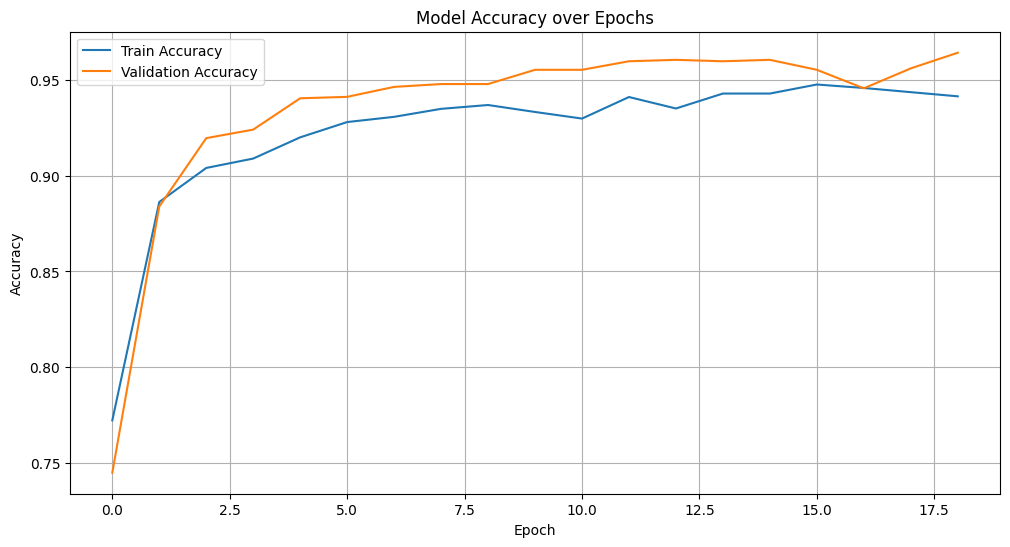

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.9376 - loss: 0.1663 - val_accuracy: 0.9643 - val_loss: 0.1130
Epoch 20/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9383 - loss: 0.1673

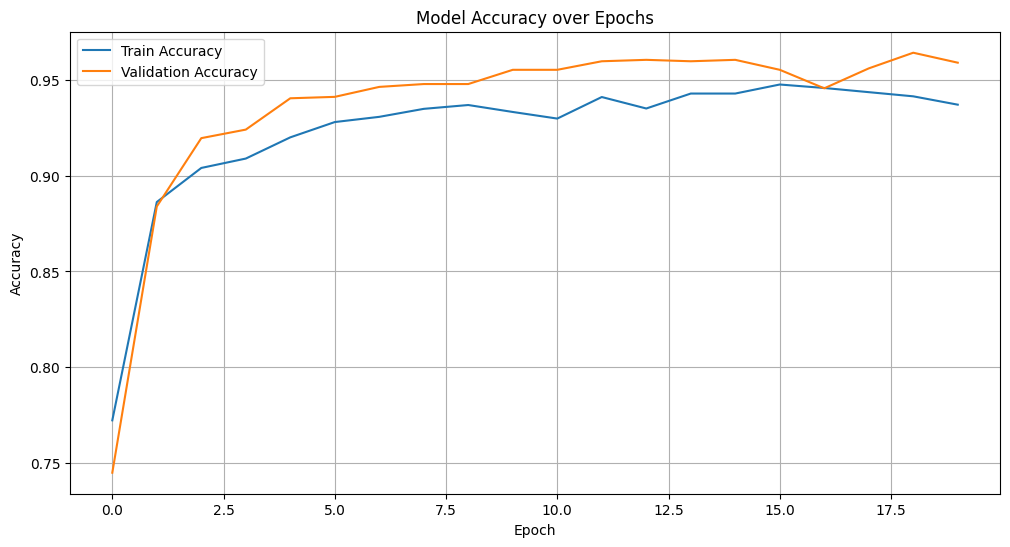

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - accuracy: 0.9383 - loss: 0.1673 - val_accuracy: 0.9591 - val_loss: 0.1186
Epoch 21/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9415 - loss: 0.1479

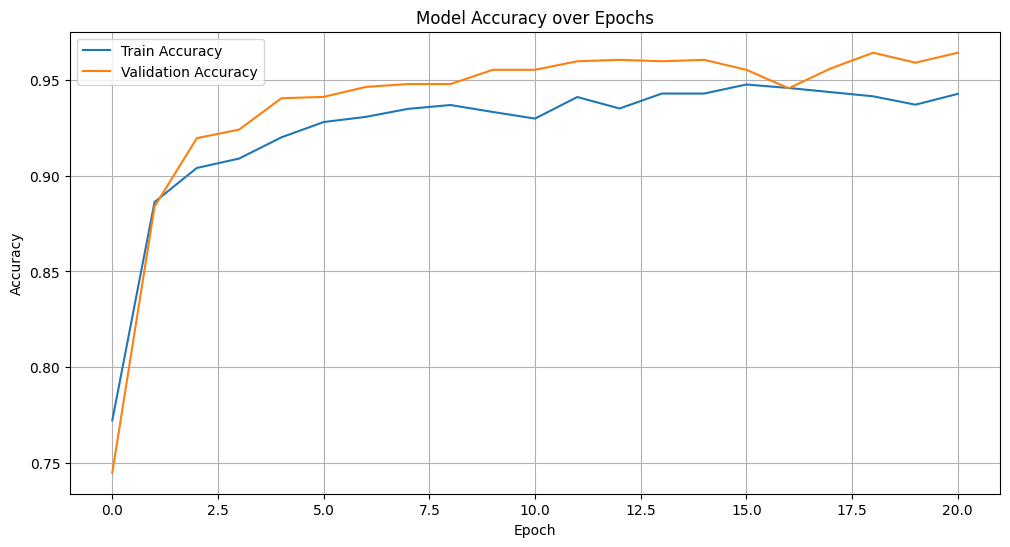

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - accuracy: 0.9415 - loss: 0.1480 - val_accuracy: 0.9643 - val_loss: 0.1136
Epoch 22/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9371 - loss: 0.1749

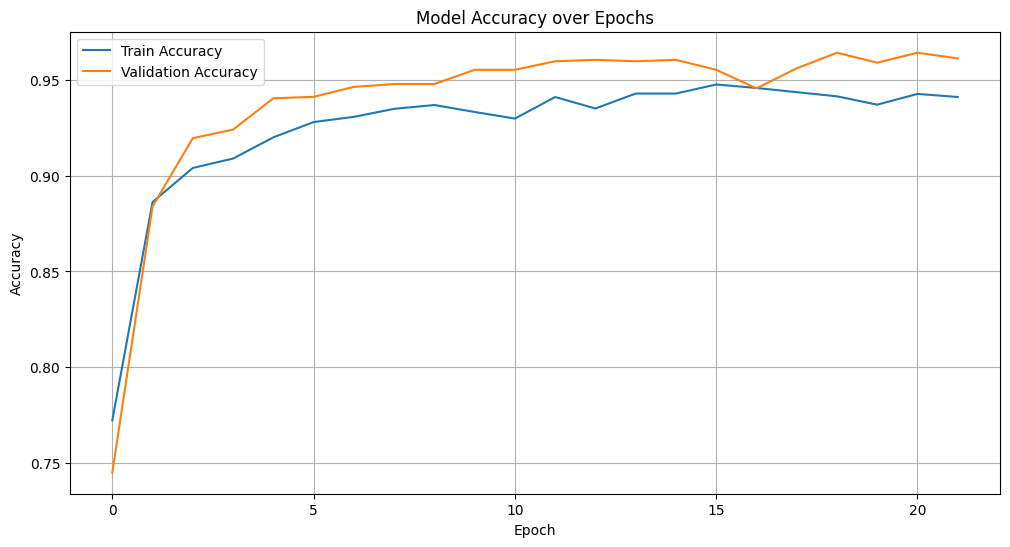

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - accuracy: 0.9371 - loss: 0.1748 - val_accuracy: 0.9613 - val_loss: 0.1250
Epoch 23/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9447 - loss: 0.1420

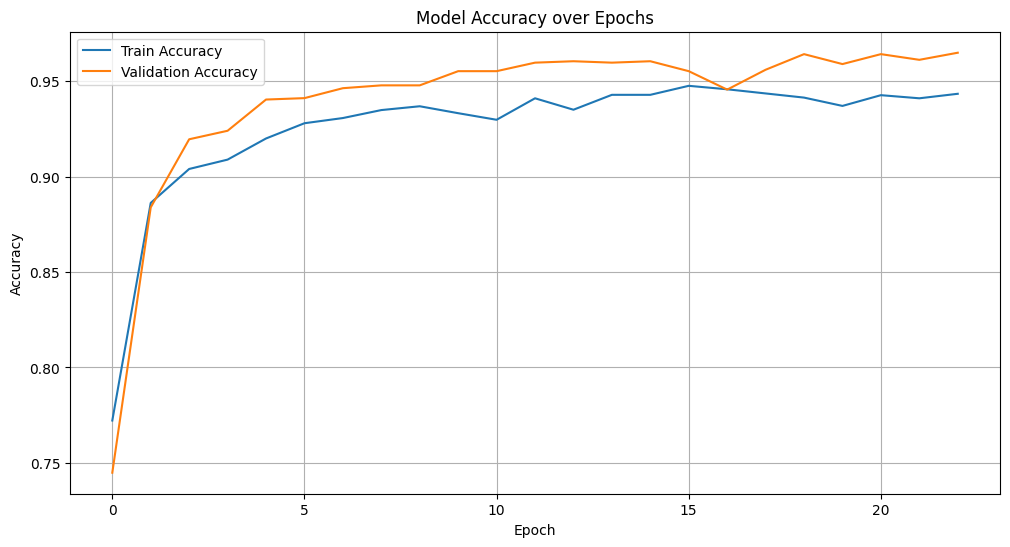

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 445ms/step - accuracy: 0.9447 - loss: 0.1421 - val_accuracy: 0.9650 - val_loss: 0.1028
Epoch 24/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9438 - loss: 0.1661

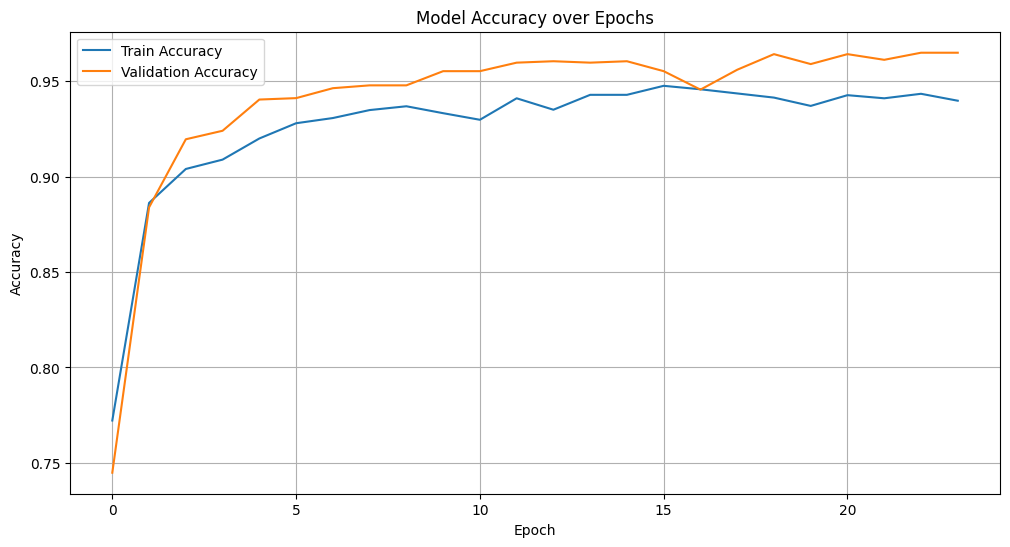

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.9437 - loss: 0.1661 - val_accuracy: 0.9650 - val_loss: 0.1045
Epoch 25/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9429 - loss: 0.1492

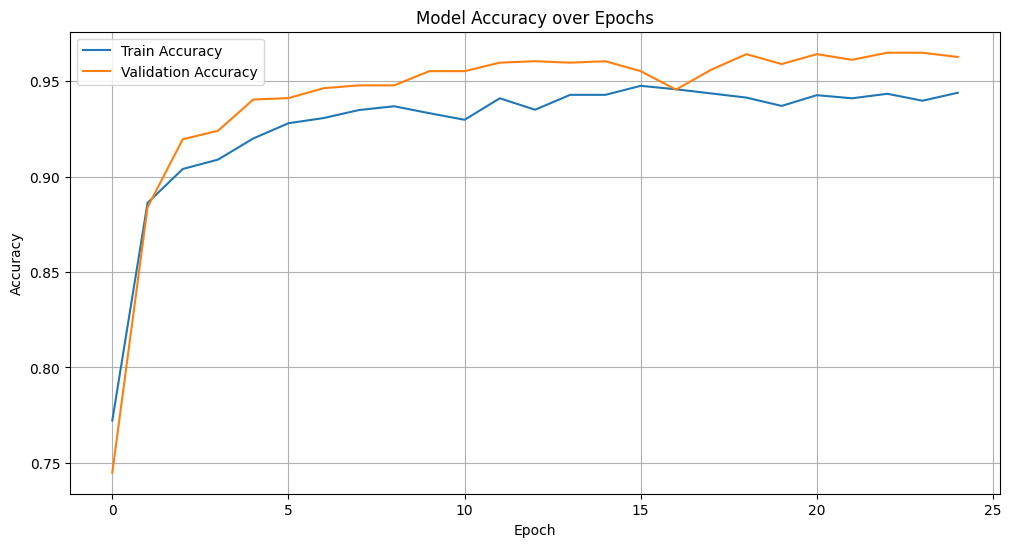

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.9429 - loss: 0.1493 - val_accuracy: 0.9628 - val_loss: 0.1114
Epoch 26/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9496 - loss: 0.1389

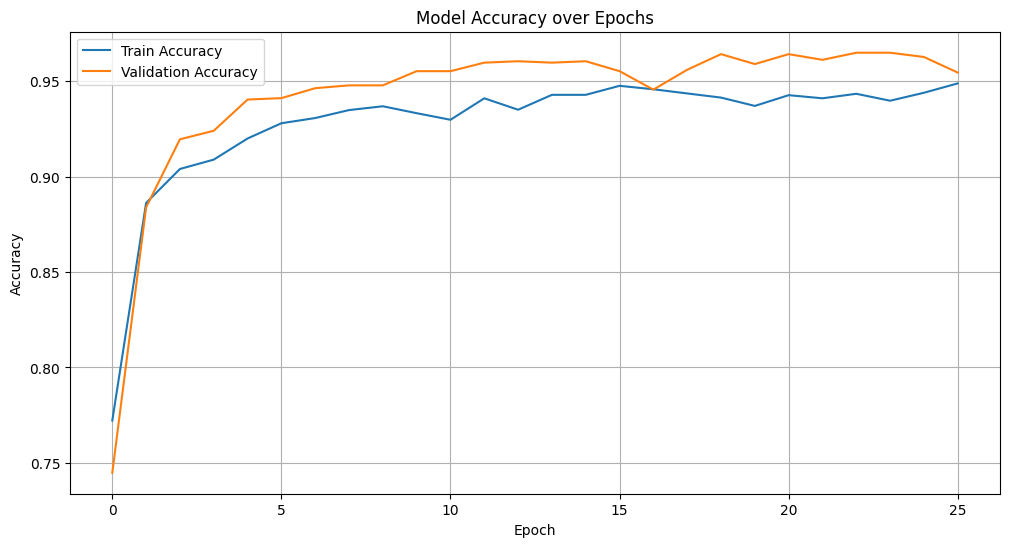

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9496 - loss: 0.1389 - val_accuracy: 0.9546 - val_loss: 0.1228
Epoch 27/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9401 - loss: 0.1805

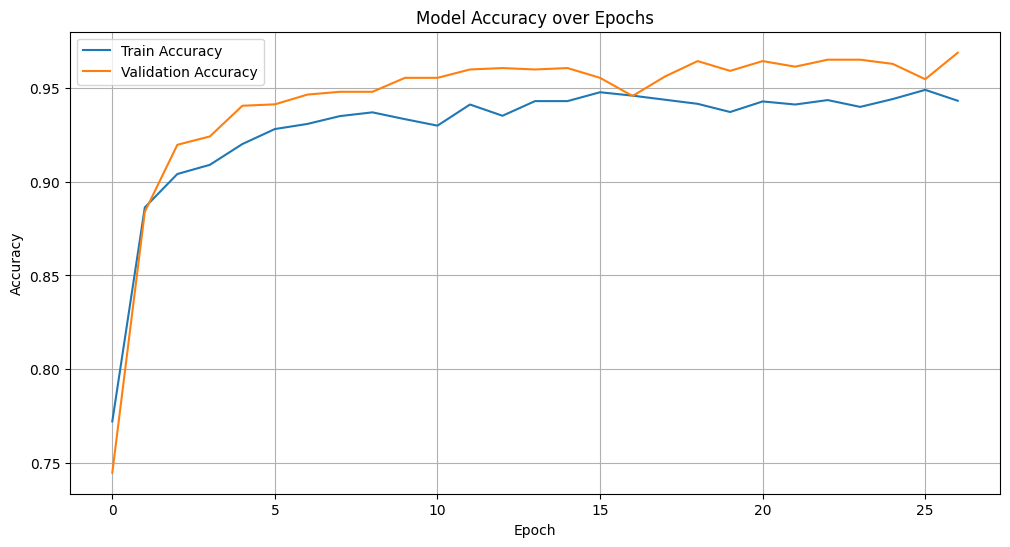

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 432ms/step - accuracy: 0.9401 - loss: 0.1803 - val_accuracy: 0.9688 - val_loss: 0.0920
Epoch 28/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9369 - loss: 0.1687

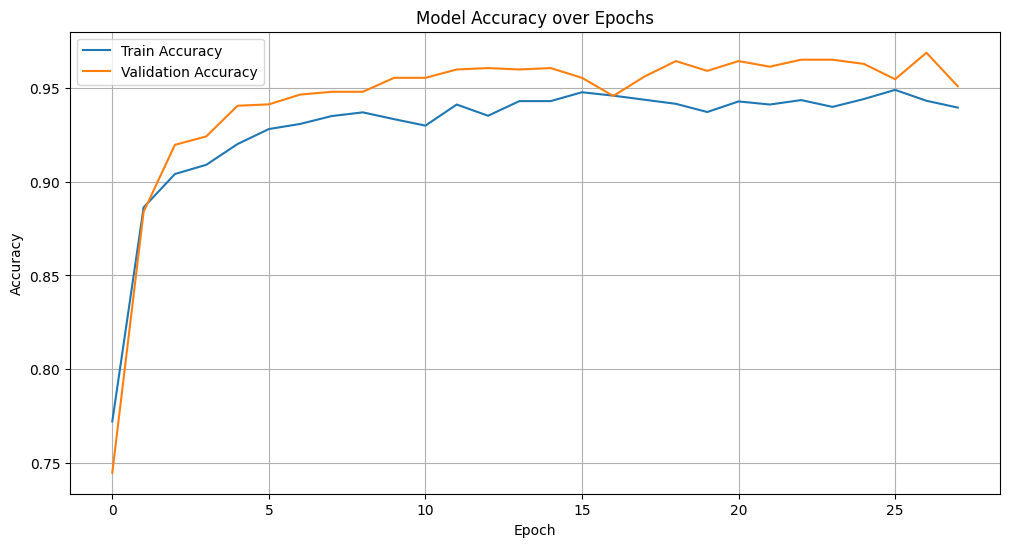

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.9369 - loss: 0.1687 - val_accuracy: 0.9509 - val_loss: 0.1299
Epoch 29/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9421 - loss: 0.1576

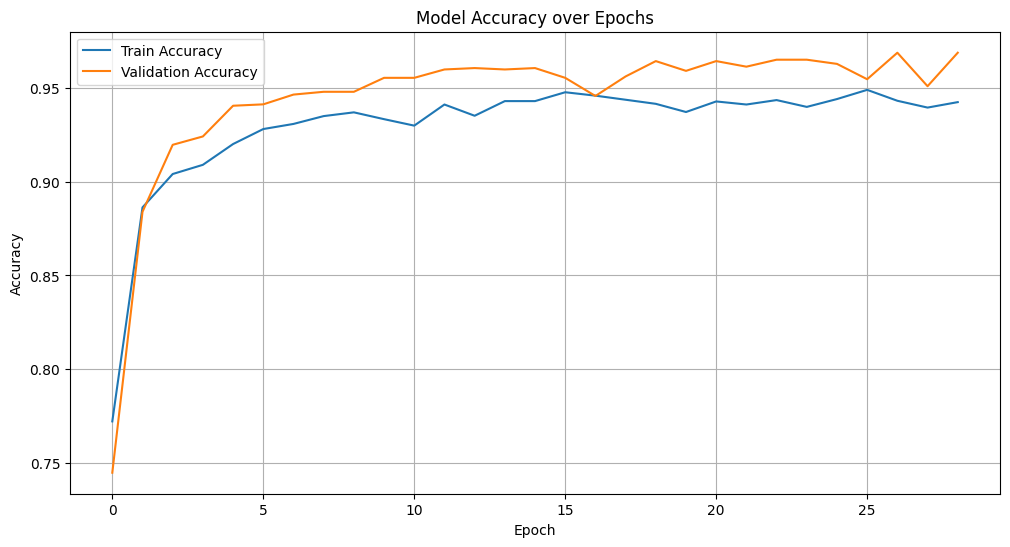

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.9421 - loss: 0.1576 - val_accuracy: 0.9688 - val_loss: 0.0959
Epoch 30/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9395 - loss: 0.1649

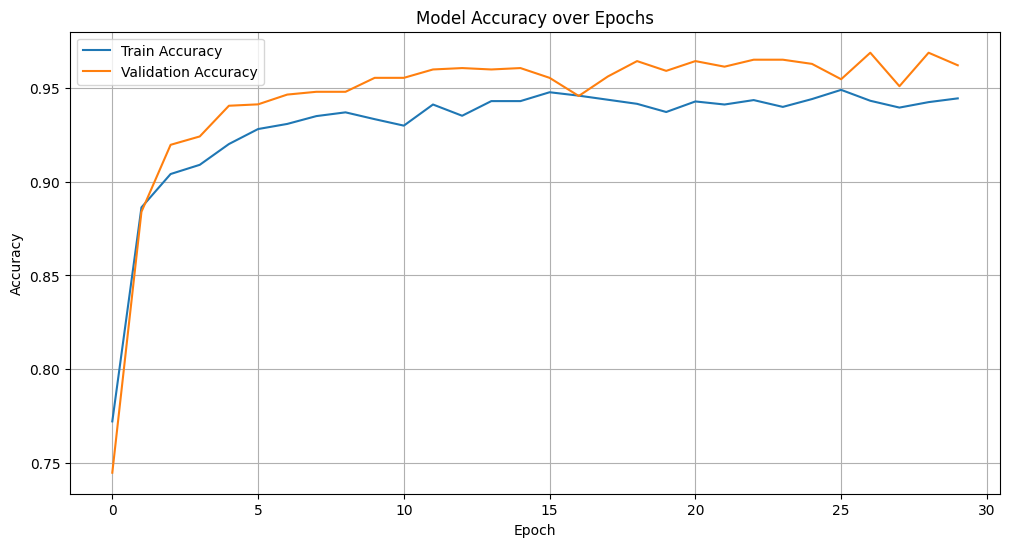

86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 425ms/step - accuracy: 0.9396 - loss: 0.1649 - val_accuracy: 0.9621 - val_loss: 0.1130
Epoch 31/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9500 - loss: 0.1394

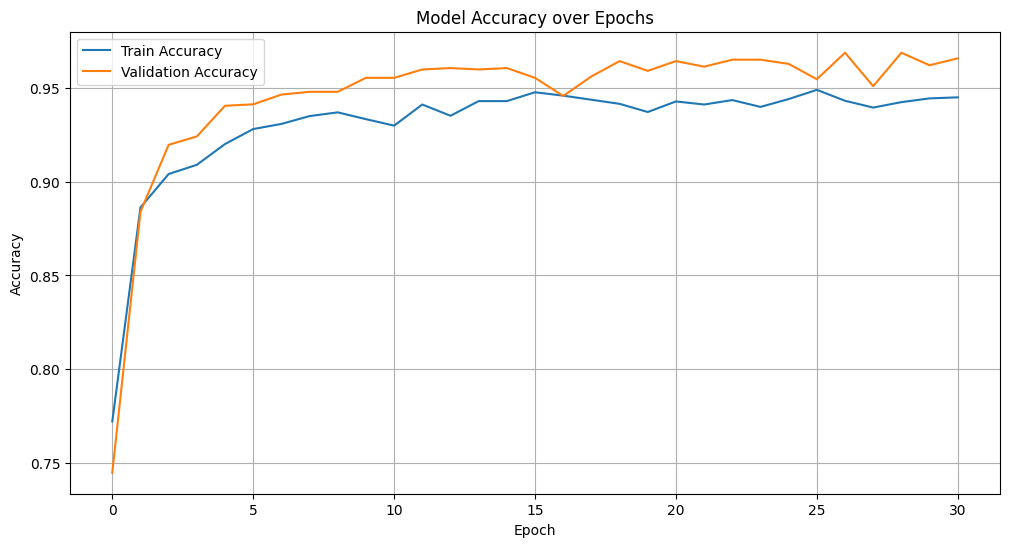

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 445ms/step - accuracy: 0.9500 - loss: 0.1395 - val_accuracy: 0.9658 - val_loss: 0.1058
Epoch 32/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9492 - loss: 0.1365

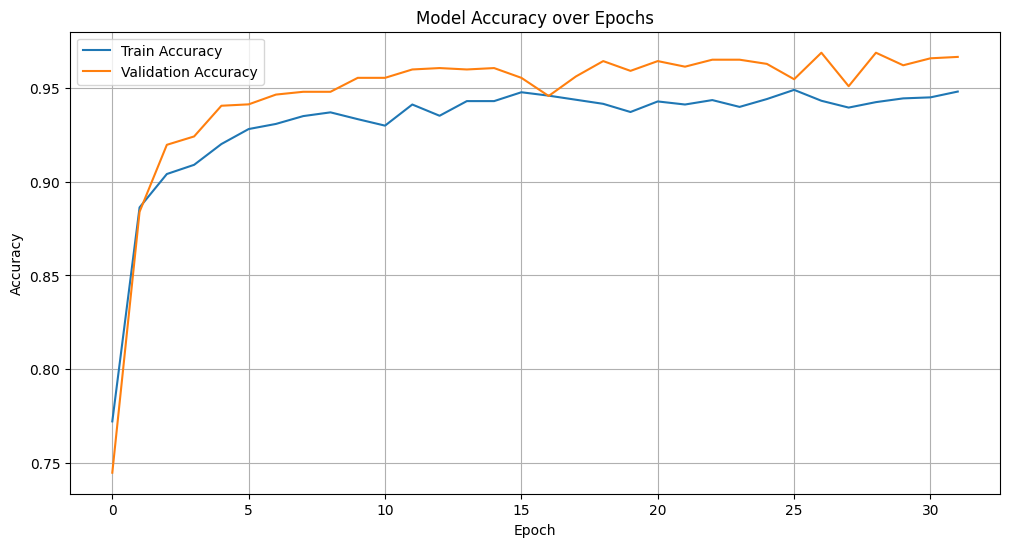

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 466ms/step - accuracy: 0.9491 - loss: 0.1366 - val_accuracy: 0.9665 - val_loss: 0.1099
Epoch 33/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9508 - loss: 0.1427

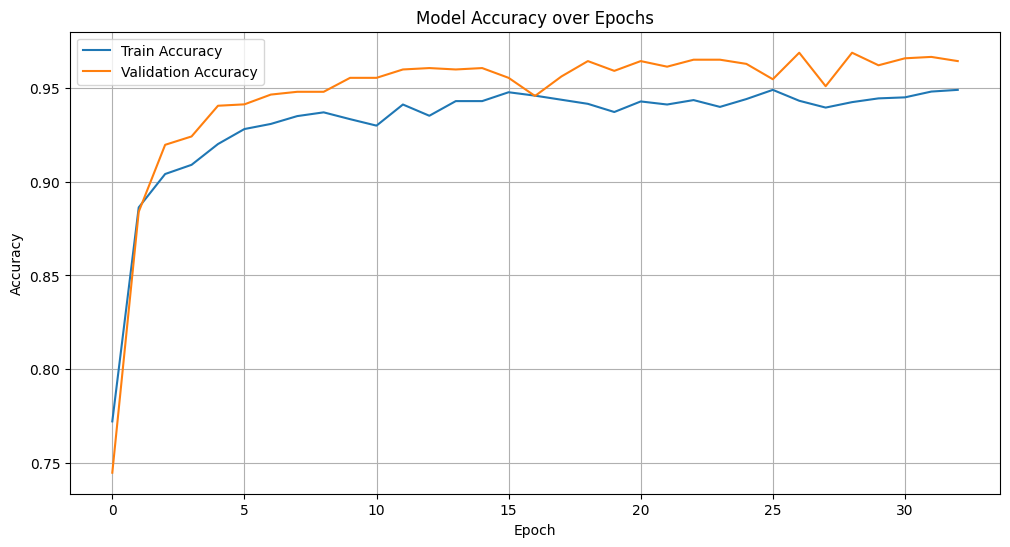

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9507 - loss: 0.1429 - val_accuracy: 0.9643 - val_loss: 0.1031
Epoch 34/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9463 - loss: 0.1534

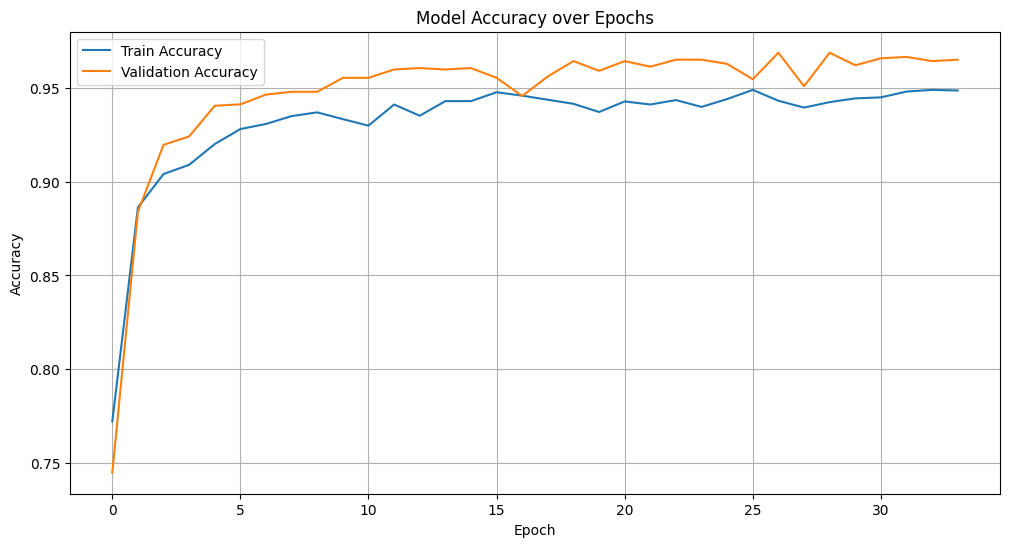

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 464ms/step - accuracy: 0.9464 - loss: 0.1534 - val_accuracy: 0.9650 - val_loss: 0.1120
Epoch 35/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9462 - loss: 0.1480

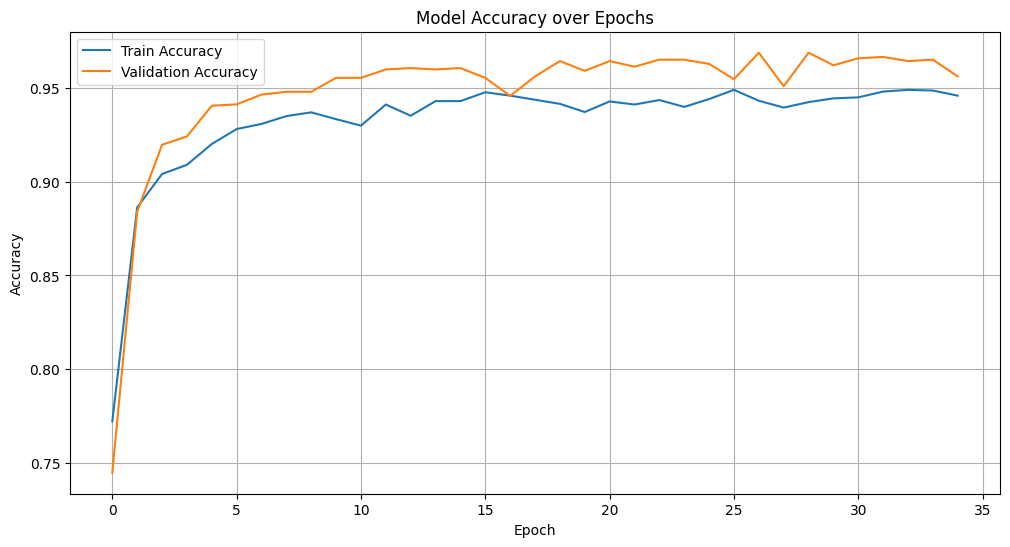

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - accuracy: 0.9462 - loss: 0.1480 - val_accuracy: 0.9561 - val_loss: 0.1269
Epoch 36/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9525 - loss: 0.1290

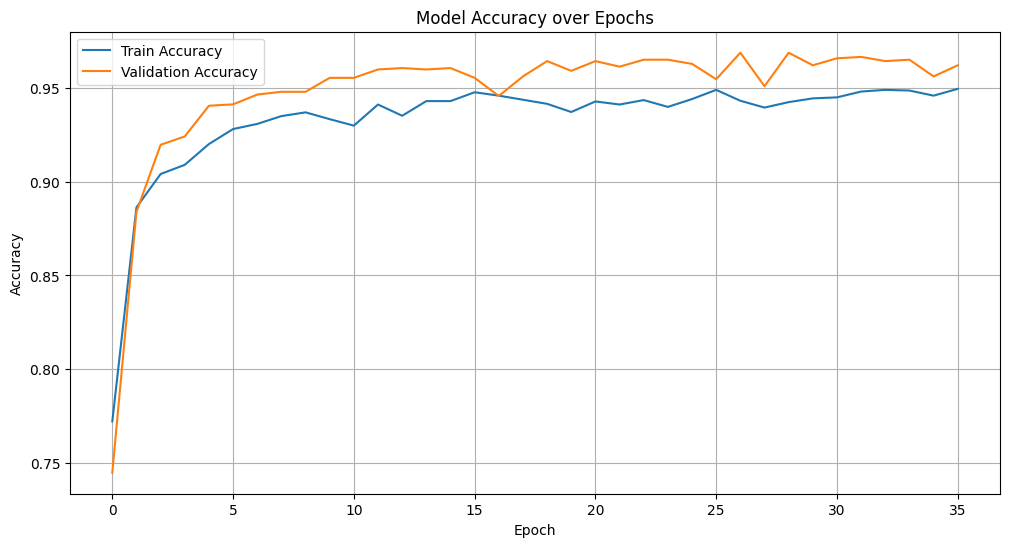

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 461ms/step - accuracy: 0.9525 - loss: 0.1291 - val_accuracy: 0.9621 - val_loss: 0.1057
Epoch 37/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9395 - loss: 0.1539

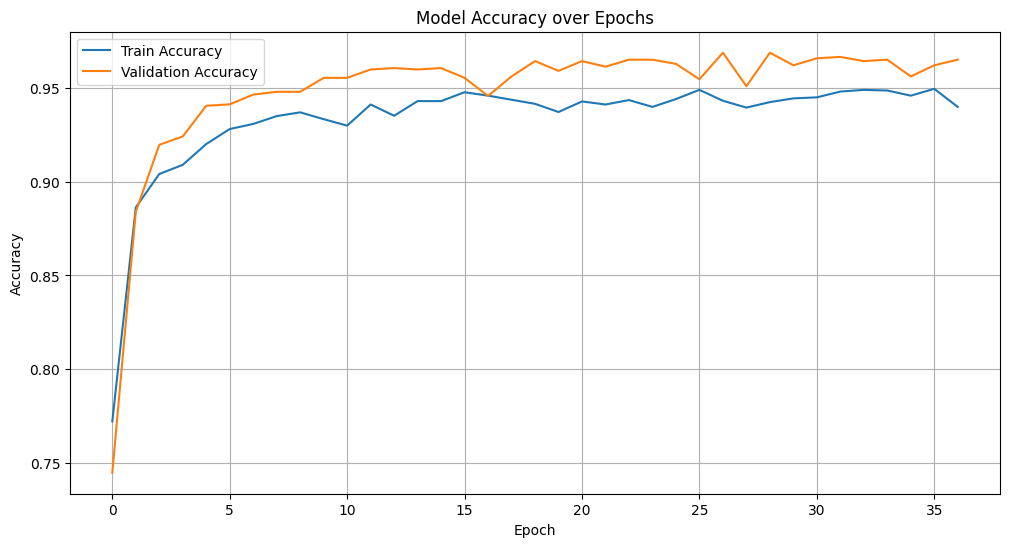

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 452ms/step - accuracy: 0.9395 - loss: 0.1540 - val_accuracy: 0.9650 - val_loss: 0.1086
Epoch 38/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9468 - loss: 0.1422

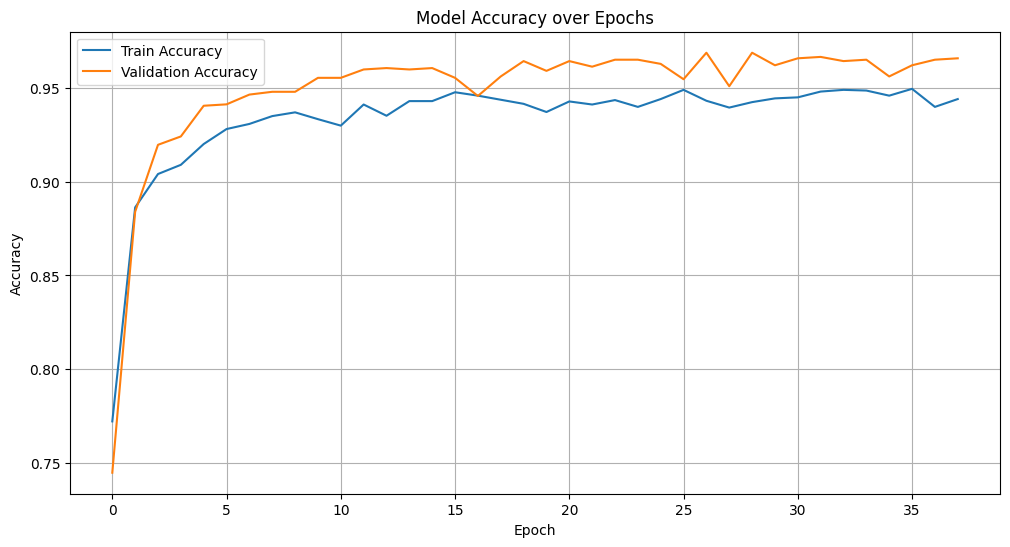

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.9467 - loss: 0.1423 - val_accuracy: 0.9658 - val_loss: 0.1029
Epoch 39/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9438 - loss: 0.1492

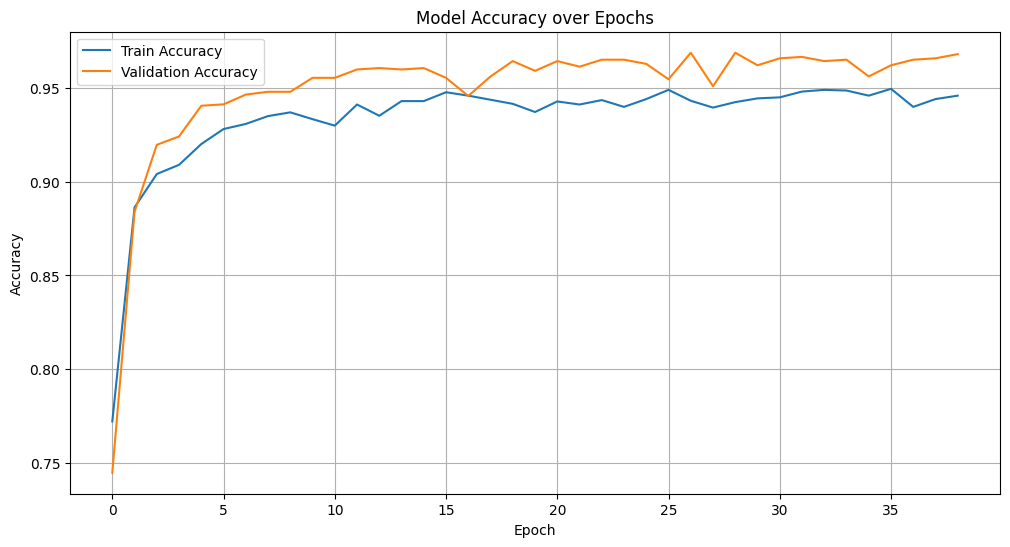

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 448ms/step - accuracy: 0.9438 - loss: 0.1492 - val_accuracy: 0.9680 - val_loss: 0.1031
Epoch 40/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9522 - loss: 0.1391

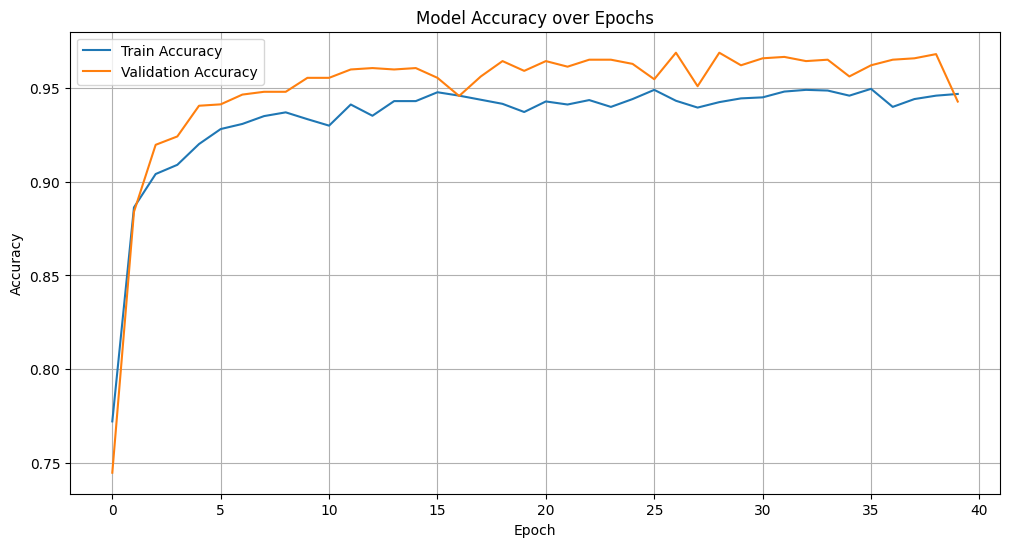

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 464ms/step - accuracy: 0.9522 - loss: 0.1392 - val_accuracy: 0.9427 - val_loss: 0.1516
Epoch 41/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9417 - loss: 0.1575

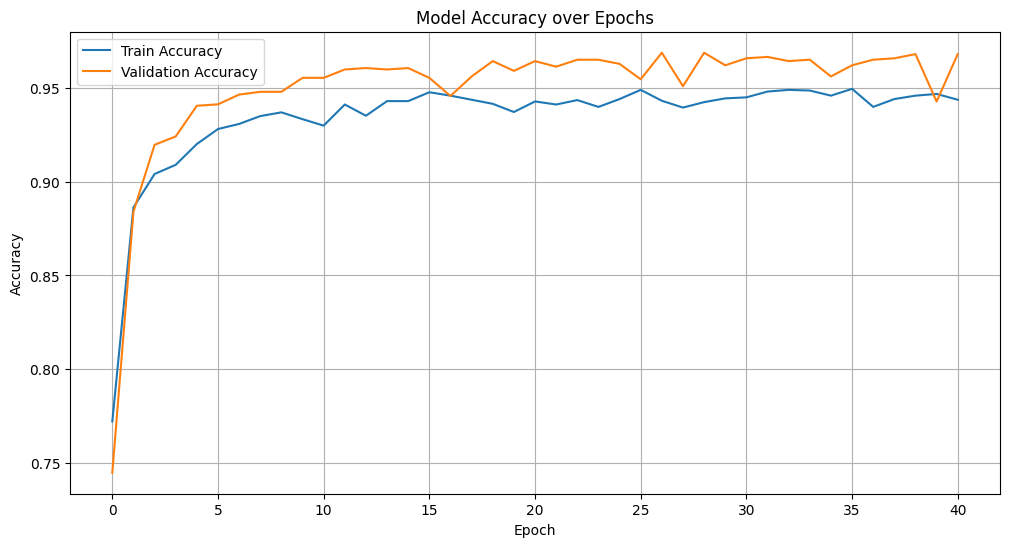

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 461ms/step - accuracy: 0.9417 - loss: 0.1574 - val_accuracy: 0.9680 - val_loss: 0.1103
Epoch 42/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9511 - loss: 0.1437

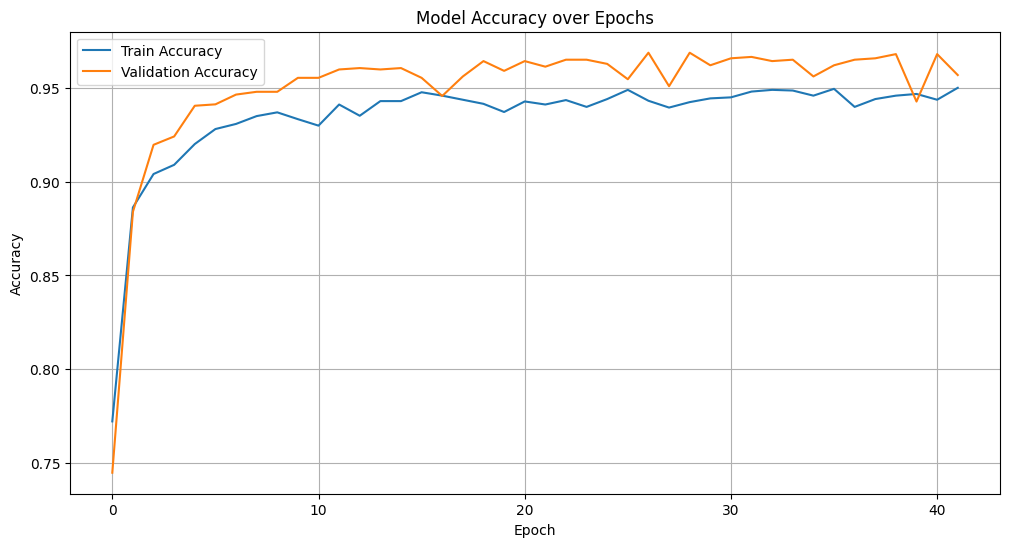

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - accuracy: 0.9511 - loss: 0.1437 - val_accuracy: 0.9568 - val_loss: 0.1192
Epoch 43/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9390 - loss: 0.1597

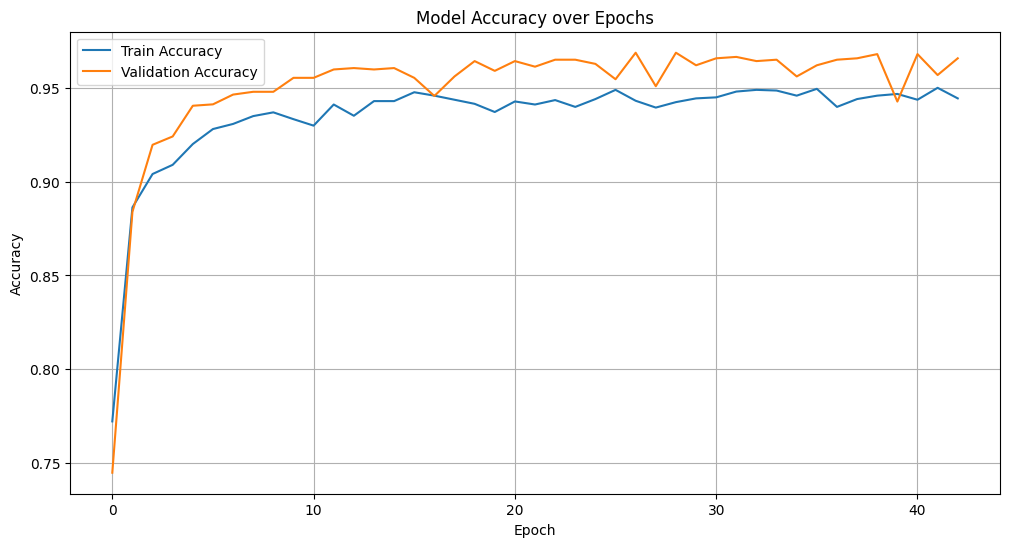

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.9391 - loss: 0.1596 - val_accuracy: 0.9658 - val_loss: 0.1136
Epoch 44/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9418 - loss: 0.1593

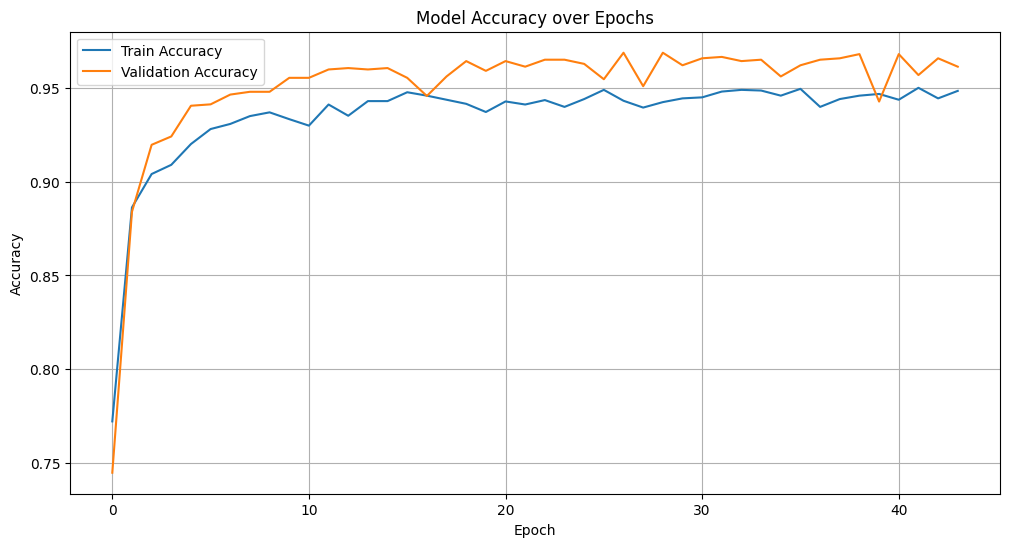

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - accuracy: 0.9419 - loss: 0.1592 - val_accuracy: 0.9613 - val_loss: 0.1176
Epoch 45/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9406 - loss: 0.1547

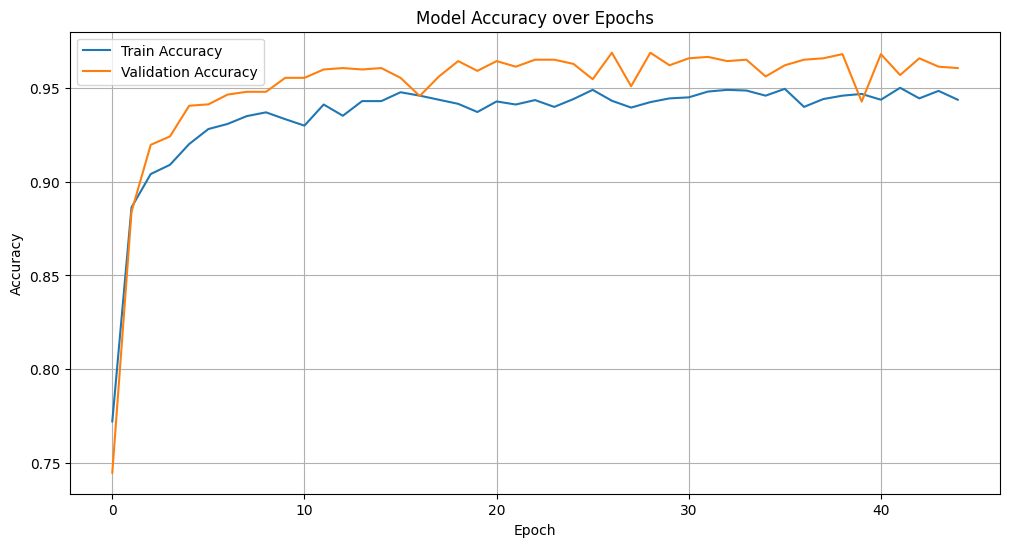

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.9406 - loss: 0.1546 - val_accuracy: 0.9606 - val_loss: 0.1123
Epoch 46/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9472 - loss: 0.1397

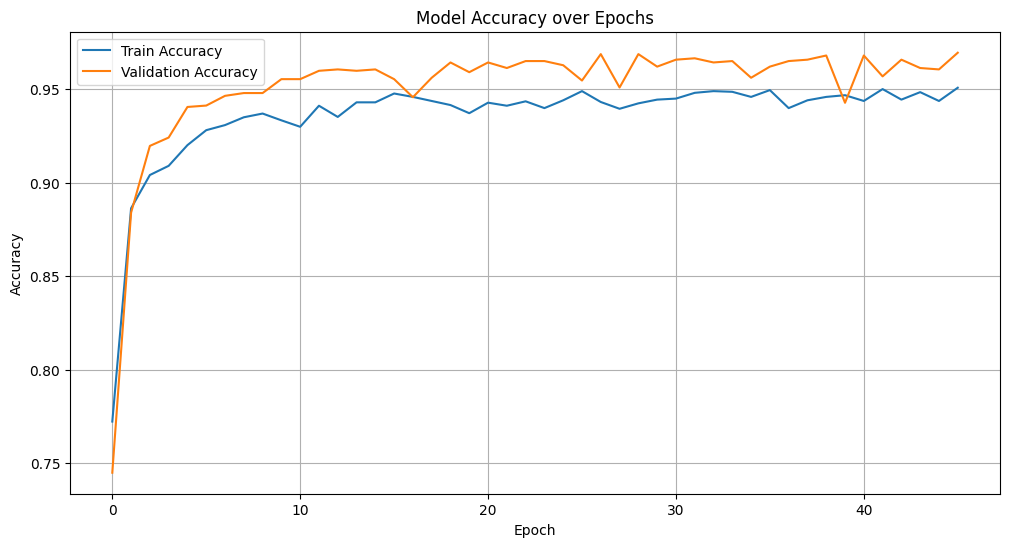

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9473 - loss: 0.1398 - val_accuracy: 0.9695 - val_loss: 0.0860
Epoch 47/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9482 - loss: 0.1413

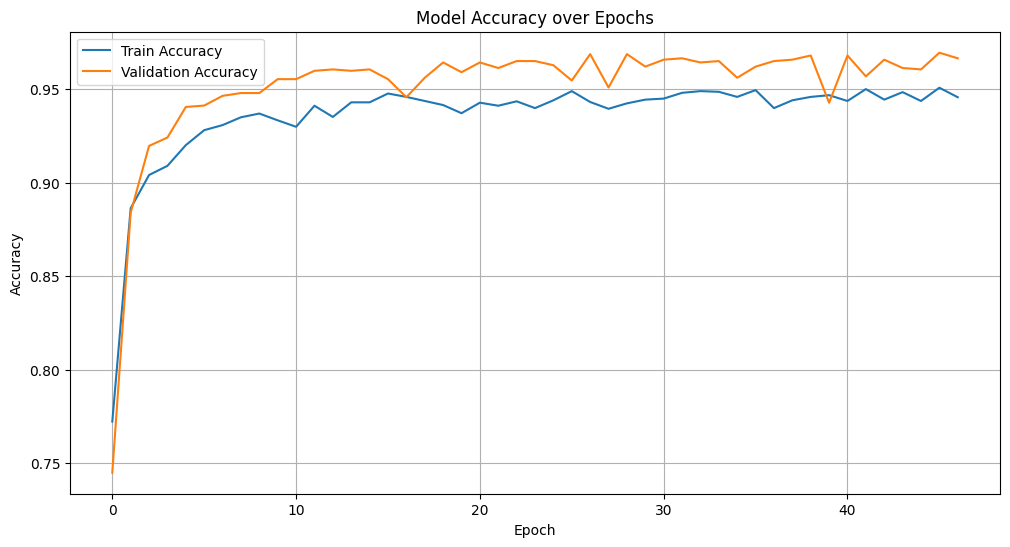

86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 454ms/step - accuracy: 0.9482 - loss: 0.1413 - val_accuracy: 0.9665 - val_loss: 0.1019
Epoch 48/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9449 - loss: 0.1605

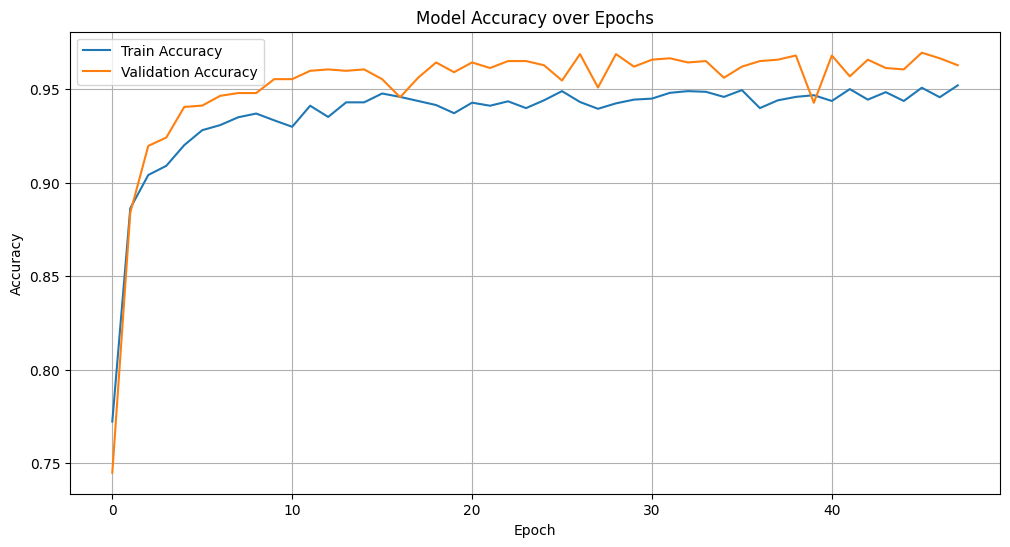

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - accuracy: 0.9450 - loss: 0.1603 - val_accuracy: 0.9628 - val_loss: 0.1036
Epoch 49/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9390 - loss: 0.1559

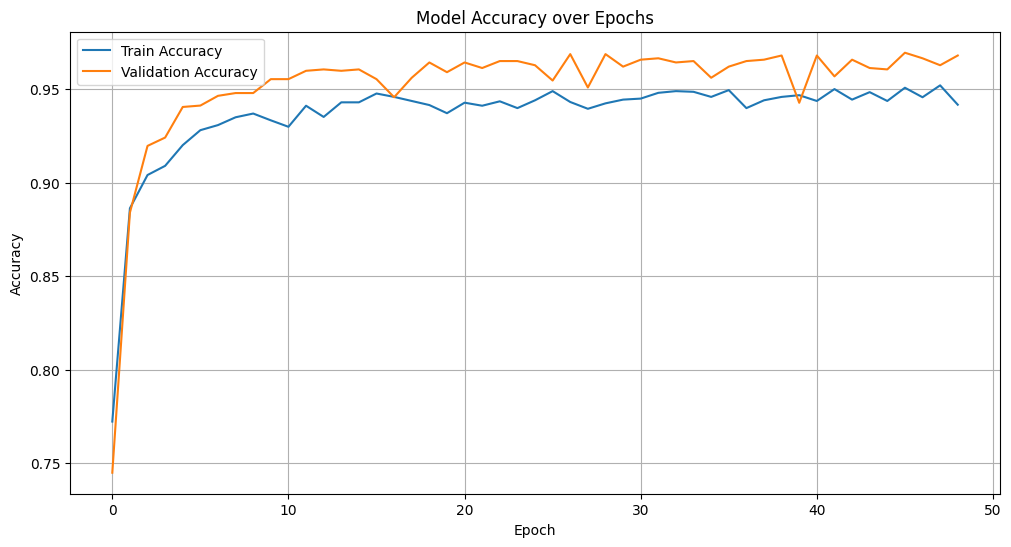

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9390 - loss: 0.1558 - val_accuracy: 0.9680 - val_loss: 0.0988
Epoch 50/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9412 - loss: 0.1539

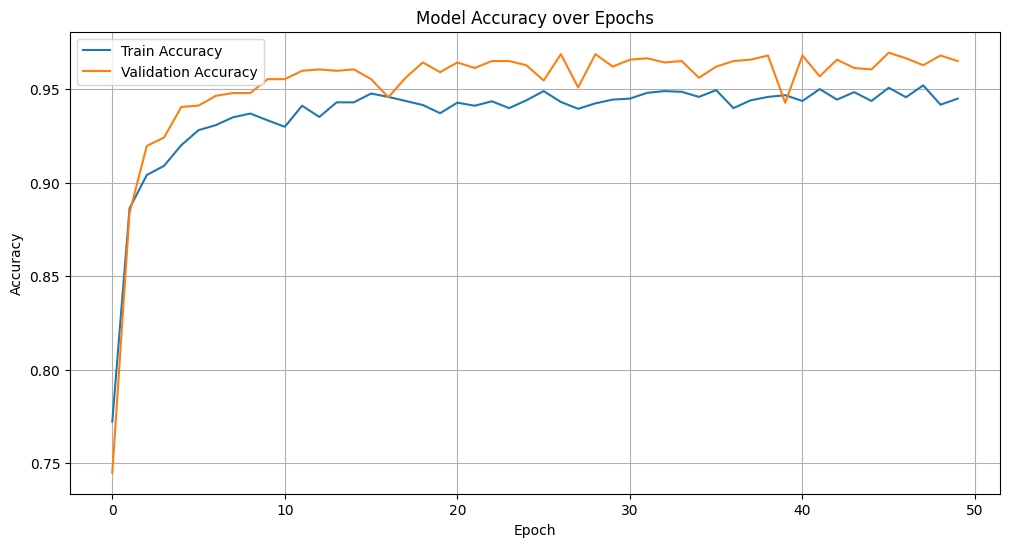

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - accuracy: 0.9413 - loss: 0.1539 - val_accuracy: 0.9650 - val_loss: 0.1071
Epoch 51/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9535 - loss: 0.1319

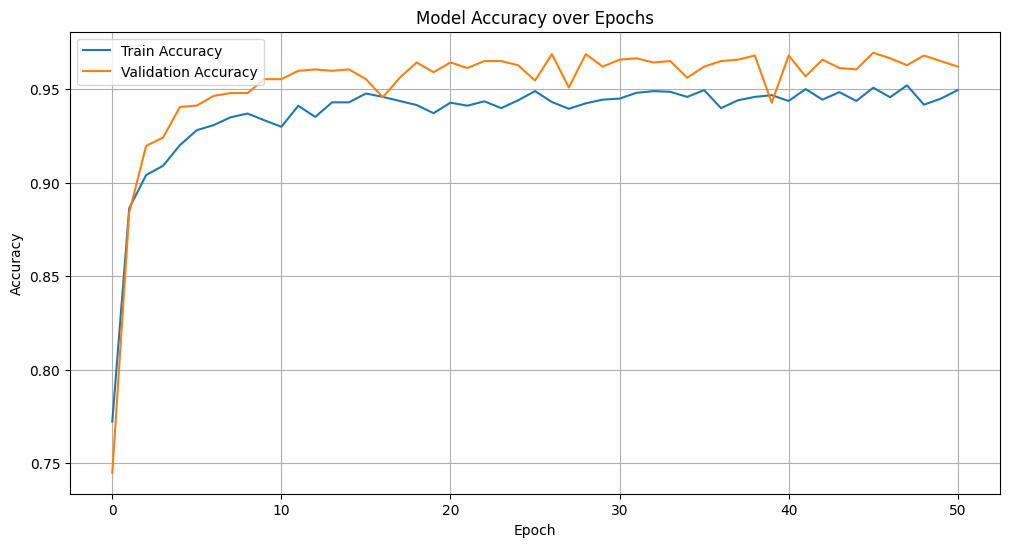

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 466ms/step - accuracy: 0.9534 - loss: 0.1320 - val_accuracy: 0.9621 - val_loss: 0.1102
Epoch 52/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9485 - loss: 0.1531

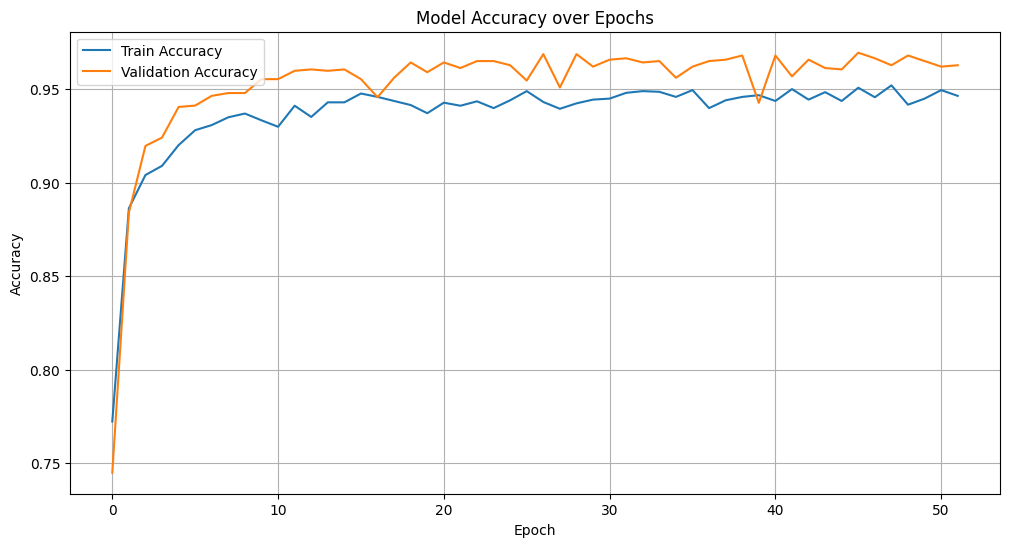

86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.9485 - loss: 0.1531 - val_accuracy: 0.9628 - val_loss: 0.1057
Epoch 53/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9413 - loss: 0.1458

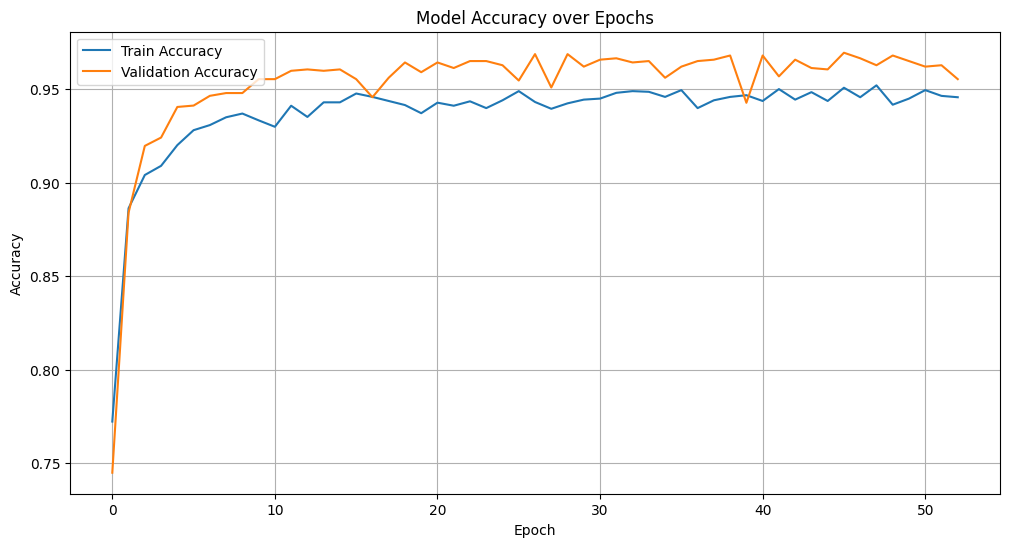

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - accuracy: 0.9414 - loss: 0.1458 - val_accuracy: 0.9554 - val_loss: 0.1156
Epoch 54/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9426 - loss: 0.1529

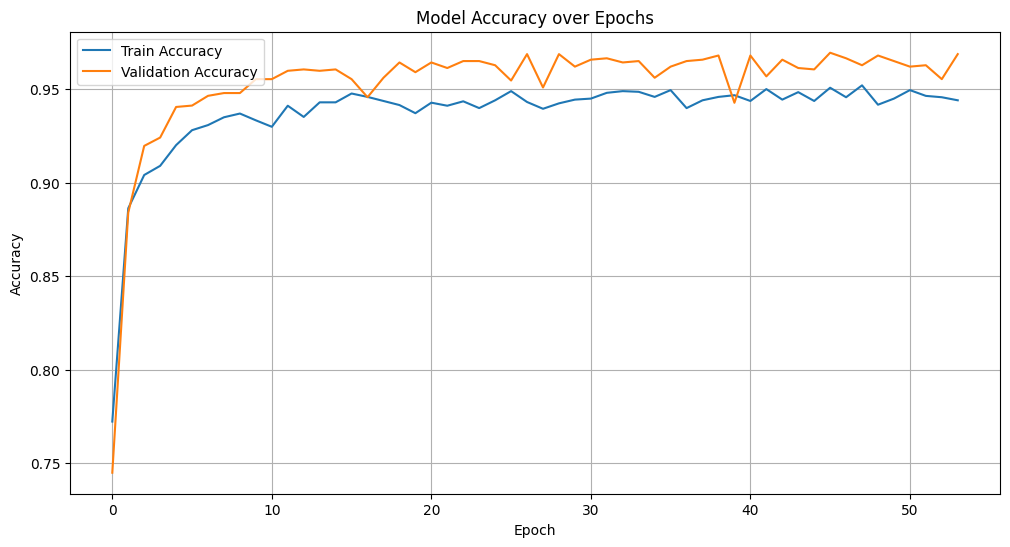

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - accuracy: 0.9426 - loss: 0.1529 - val_accuracy: 0.9688 - val_loss: 0.0973
Epoch 55/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9407 - loss: 0.1588

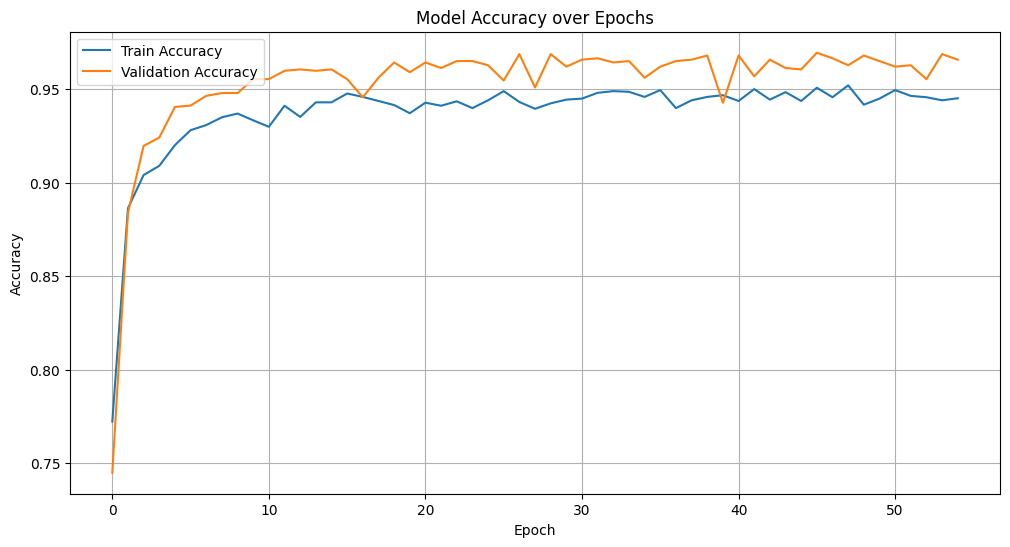

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9408 - loss: 0.1587 - val_accuracy: 0.9658 - val_loss: 0.1038
Epoch 56/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9486 - loss: 0.1380

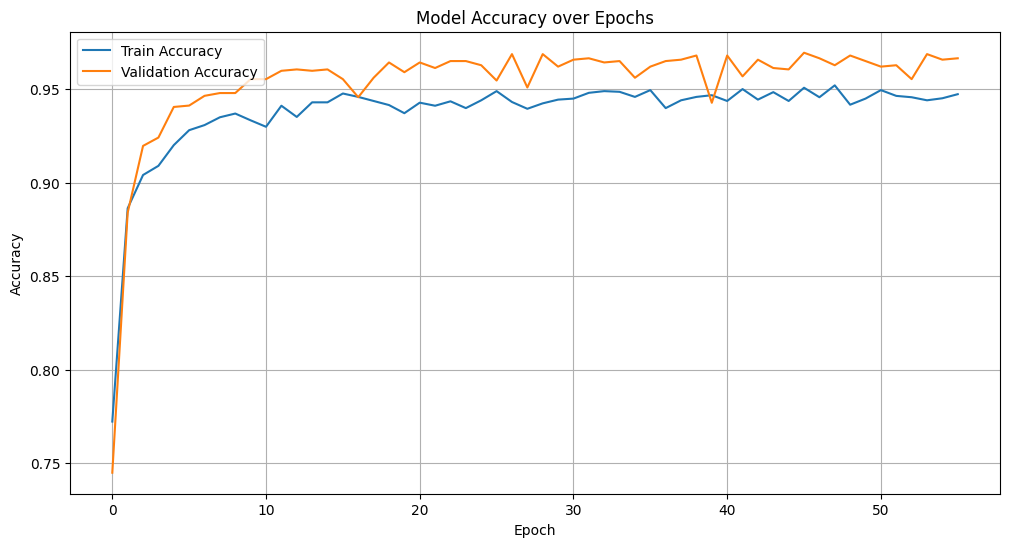

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.9486 - loss: 0.1381 - val_accuracy: 0.9665 - val_loss: 0.0912
Epoch 57/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9505 - loss: 0.1422

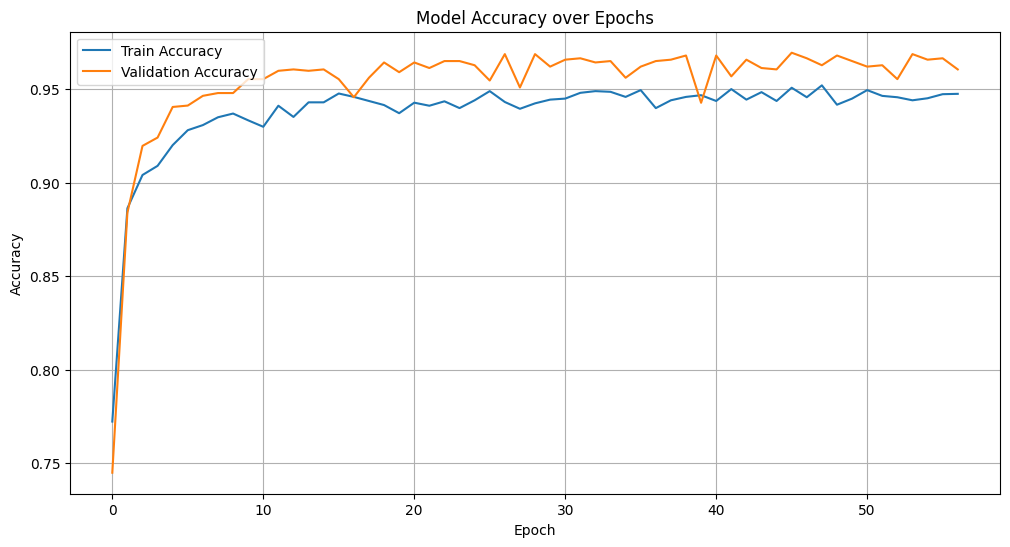

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 469ms/step - accuracy: 0.9505 - loss: 0.1423 - val_accuracy: 0.9606 - val_loss: 0.1185
Epoch 58/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9400 - loss: 0.1552

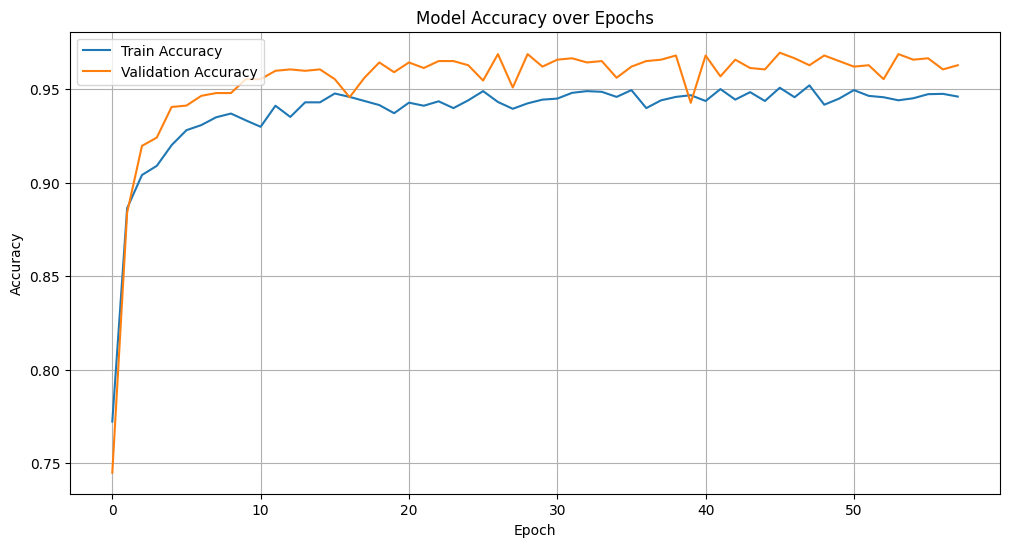

86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - accuracy: 0.9400 - loss: 0.1551 - val_accuracy: 0.9628 - val_loss: 0.0983
Epoch 59/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9400 - loss: 0.1581

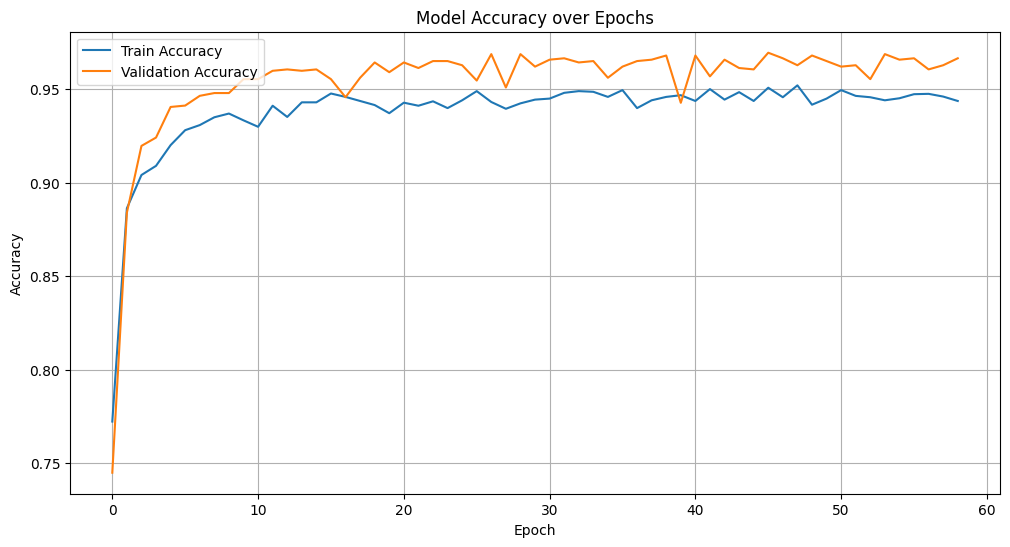

86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9401 - loss: 0.1580 - val_accuracy: 0.9665 - val_loss: 0.0989
Epoch 60/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9487 - loss: 0.1341

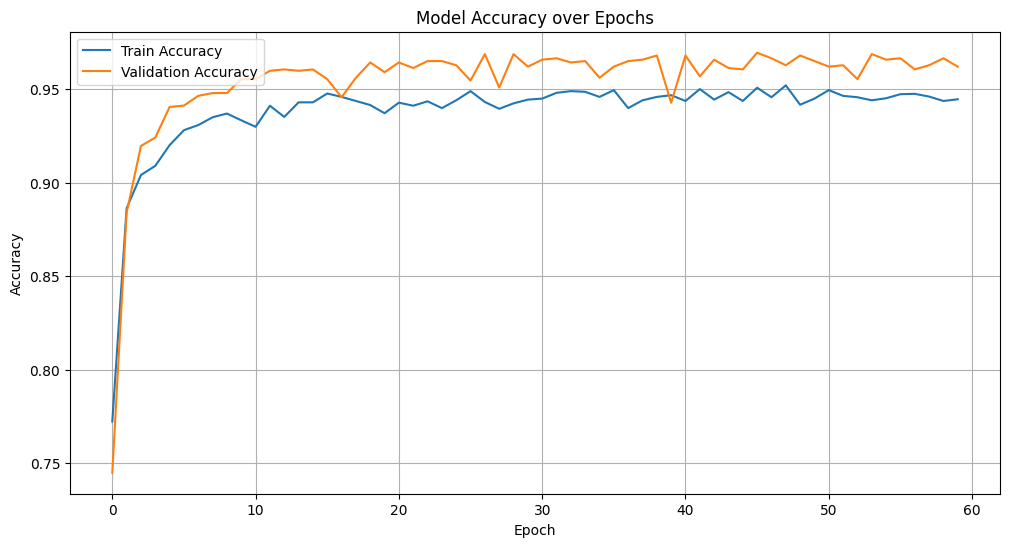

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 463ms/step - accuracy: 0.9486 - loss: 0.1343 - val_accuracy: 0.9621 - val_loss: 0.1081


In [ ]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 60  # @param {type: "slider", min:8, max:80}
plot_metrics = PlotMetrics()
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[plot_metrics])

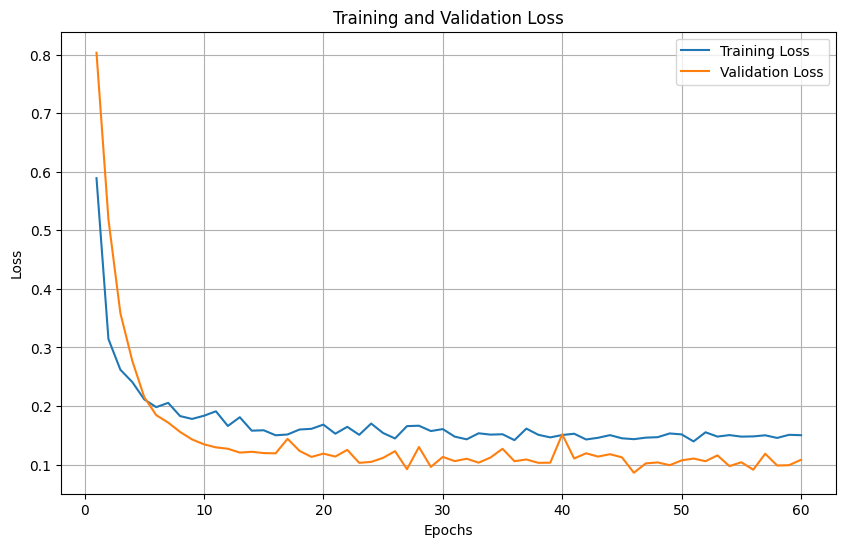

In [ ]:
import matplotlib.pyplot as plt

# Define the training and validation loss values obtained during training
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
epochs = range(1, len(training_loss) + 1)  # Number of epochs

# Plot the training and validation loss over the number of epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('/content/drive/Shareddrives/FYP/model/efficientnetb0_model_0404_Best.h5')  # Save in HDF5 format or use the SavedModel format

print("Model saved as 'efficientnetb0_model.h5'")

Model saved as 'efficientnetb0_model.h5'


In [ ]:
# Assuming you have loaded your test dataset with both input data and labels
test_loss, test_accuracy = model.evaluate(ds_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9625 - loss: 0.1043
Test Loss: 0.10426246374845505
Test Accuracy: 0.9642857313156128


Found 5560 files belonging to 4 classes.
Labels shape: (5560,)


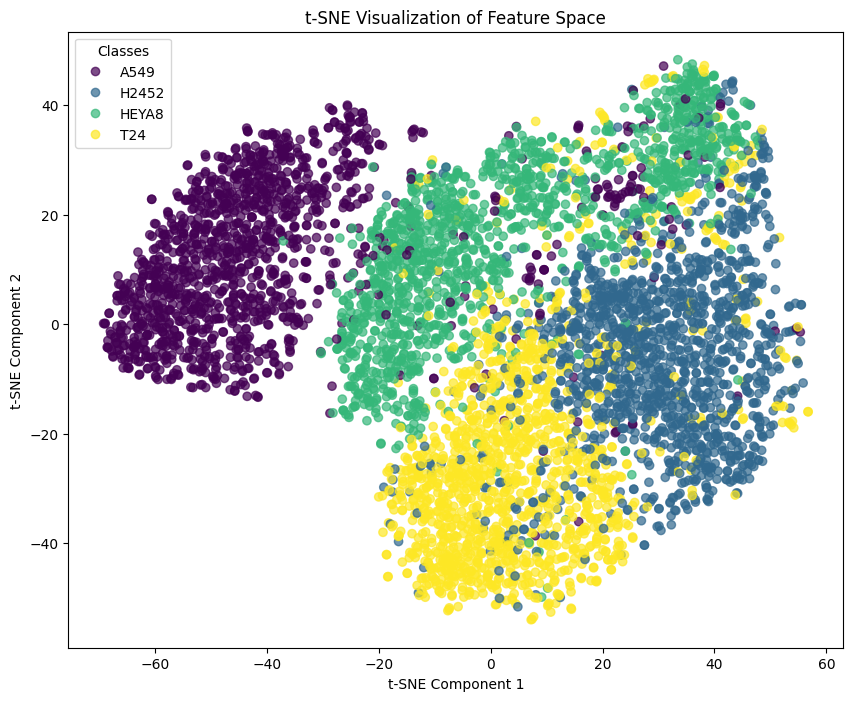

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
import tensorflow as tf

# Define constants
IMG_SIZE = 224  # Adjust based on your model's input size
NUM_CLASSES = 4  # Specify the number of classes


# Create a feature extractor model
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Load the dataset as grayscale
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/Shareddrives/FYP/single_cell_data/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    color_mode='grayscale'
)

# Step 1: Extract features from the model
features = []
labels = []

for images, label in ds_train:
    # Extract features
    feature_batch = feature_extractor(images).numpy()
    features.append(feature_batch)
    labels.append(label.numpy())

# Concatenate all features and labels
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Check the shape of the labels
print("Labels shape:", labels.shape)

# Ensure labels are in the correct format for t-SNE
if len(labels.shape) == 1:  # If labels are one-dimensional
    labels = np.eye(NUM_CLASSES)[labels]  # Convert to one-hot encoding

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)


class_names = {
    0: 'A549',
    1: 'H2452',
    2: 'HEYA8',
    3: 'T24'
}

# Step 3: Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.argmax(labels, axis=1), cmap='viridis', alpha=0.7)
# plt.colorbar(scatter)
handles, _ = scatter.legend_elements()
custom_labels = [class_names[label] for label in np.unique(np.argmax(labels, axis=1))]
plt.legend(handles, custom_labels, title='Classes', loc='best')

plt.title('t-SNE Visualization of Feature Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# Load the trained model
# MODEL_PATH = "/content/drive/Shareddrives/FYP/model/efficientnetb0_model_0404_Best.h5"
# model = load_model(MODEL_PATH)

# Define the preprocessing function
def preprocess_crop(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = tf.image.rgb_to_grayscale(img)
    return img

# Define the class labels
class_labels = ['A549', 'H2452', 'HEYA8', 'T24']

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Predict images from the validation folder
validation_dir = "/content/drive/Shareddrives/FYP/single_cell_data/validation"
for class_label in class_labels:
    class_dir = os.path.join(validation_dir, class_label)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)  # Adjust channels as per your images
        img = preprocess_crop(img)
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        pred = model.predict(img)
        predicted_label = class_labels[np.argmax(pred)]
        true_labels.append(class_label)
        predicted_labels.append(predicted_label)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

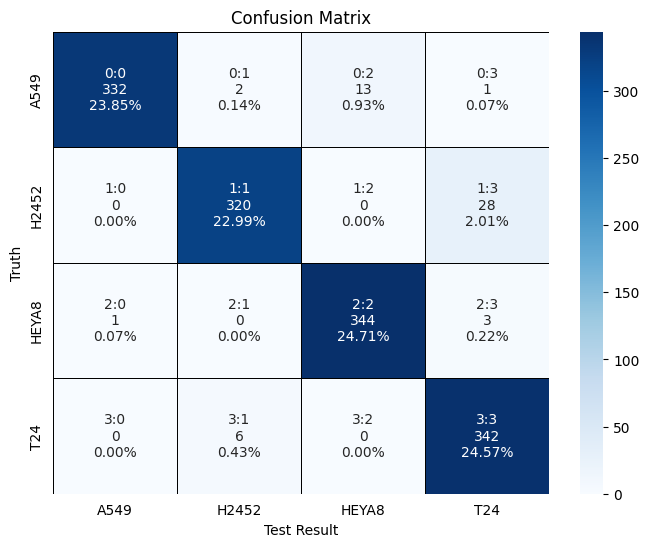

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
group_names = ["0:0", "0:1", "0:2", "0:3",
               "1:0", "1:1", "1:2", "1:3",
               "2:0", "2:1", "2:2", "2:3",
               "3:0", "3:1", "3:2", "3:3"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(4, 4)  # Change to 4x4 for 4 classes

x_axis_labels = ['A549', 'H2452', 'HEYA8', 'T24']  # labels for x-axis
y_axis_labels = ['A549', 'H2452', 'HEYA8', 'T24']  # labels for y-axis

plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
ax = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', linecolor='black',
                 xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidths=.5)
ax.tick_params(left=False, bottom=False)

ax.set(xlabel='Test Result', ylabel='Truth')
plt.title('Confusion Matrix')  # Optional: Add a title
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print('\n--------------- Classification Report ---------------\n')
print(report)


--------------- Classification Report ---------------

              precision    recall  f1-score   support

        A549       1.00      0.95      0.98       348
       H2452       0.98      0.92      0.95       348
       HEYA8       0.96      0.99      0.98       348
         T24       0.91      0.98      0.95       348

    accuracy                           0.96      1392
   macro avg       0.96      0.96      0.96      1392
weighted avg       0.96      0.96      0.96      1392



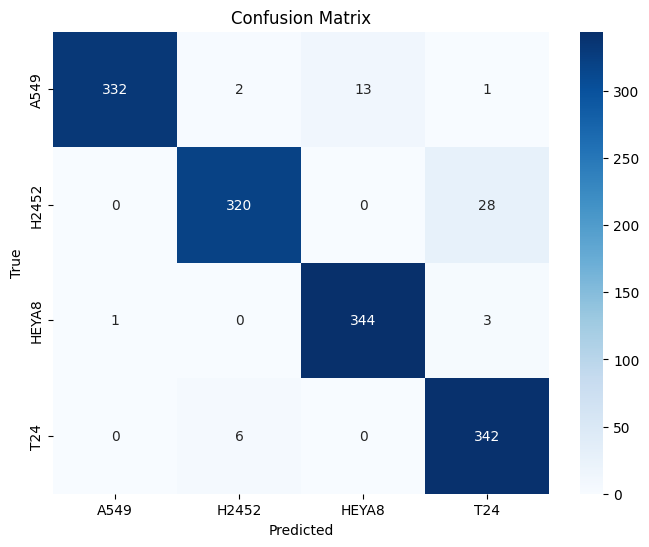

+--------------+--------------------+--------------------+--------------------+--------+
|      0       |         1          |         2          |         3          |   4    |
+--------------+--------------------+--------------------+--------------------+--------+
|     A549     | 0.996996996996997  | 0.9540229885057471 | 0.9750367107195301 | 348.0  |
|    H2452     | 0.975609756097561  | 0.9195402298850575 | 0.9467455621301775 | 348.0  |
|    HEYA8     | 0.9635854341736695 | 0.9885057471264368 | 0.975886524822695  | 348.0  |
|     T24      | 0.9144385026737968 | 0.9827586206896551 | 0.9473684210526315 | 348.0  |
|   accuracy   | 0.9612068965517241 |                    |                    |        |
|  macro avg   | 0.962657672485506  | 0.9612068965517241 | 0.9612593046812585 | 1392.0 |
| weighted avg | 0.962657672485506  | 0.9612068965517241 | 0.9612593046812585 | 1392.0 |
+--------------+--------------------+--------------------+--------------------+--------+


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
report_dict = classification_report(true_labels, predicted_labels, target_names=class_labels, output_dict=True)

# Convert the classification report dictionary to a list of lists
report_list = []
for key, values in report_dict.items():
    if isinstance(values, dict):
        row = [key] + list(values.values())
    else:
        row = [key, values]
    report_list.append(row)

# Display the classification report as a table
report_table = tabulate(report_list, headers='keys', tablefmt='pretty')
print(report_table)